In [1]:
import copy
import os
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import scipy as sp

from yass.evaluate.stability import *
from yass.evaluate.util import *
from yass.geometry import parse, find_channel_neighbors
from yass.evaluate.visualization import WaveFormTrace

from deconv_exp_utils import *

import tensorflow as tf

from tqdm import tqdm

%matplotlib inline

/home/hooshmand/Documents/github/yassenv/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
base_dir = '/ssd/data/peter/ej49_dataset'

raw = os.path.join(base_dir, 'ej49_data1_set1.bin')
geom = os.path.join(base_dir, 'ej49_geometry1.txt')
st_file = os.path.join(base_dir, 'groundtruth_ej49_data1_set1.mat')

rbi = RecordingBatchIterator(
    rec_file=raw, n_chan=49, batch_time_samples=1000000,
    geom_file=geom, n_batches=6, radius=70, sample_rate=20000,
    whiten=False)

In [3]:
gold_sp = sio.loadmat(st_file)
gold_sp = np.append(gold_sp['spt_gt'], gold_sp['L_gt'])
gold_sp = gold_sp.reshape([2, len(gold_sp) // 2]).T

gold_sp

array([[      7,      40],
       [     13,      27],
       [     51,      29],
       ...,
       [5999929,      46],
       [5999931,      34],
       [5999991,       8]], dtype=int32)

In [4]:
mwc = MeanWaveCalculator(batch_reader=rbi, spike_train=gold_sp, window=range(-20, 30))
mwc.compute_templates(6)

100%|██████████| 6/6 [00:23<00:00,  3.94s/it]


8

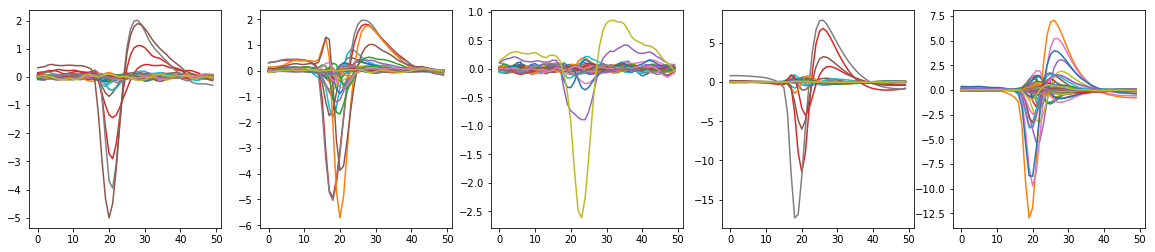

In [5]:
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].plot(mwc.templates[:, :, i])
fig.set_size_inches(20, 4)

# Alignment with main channel

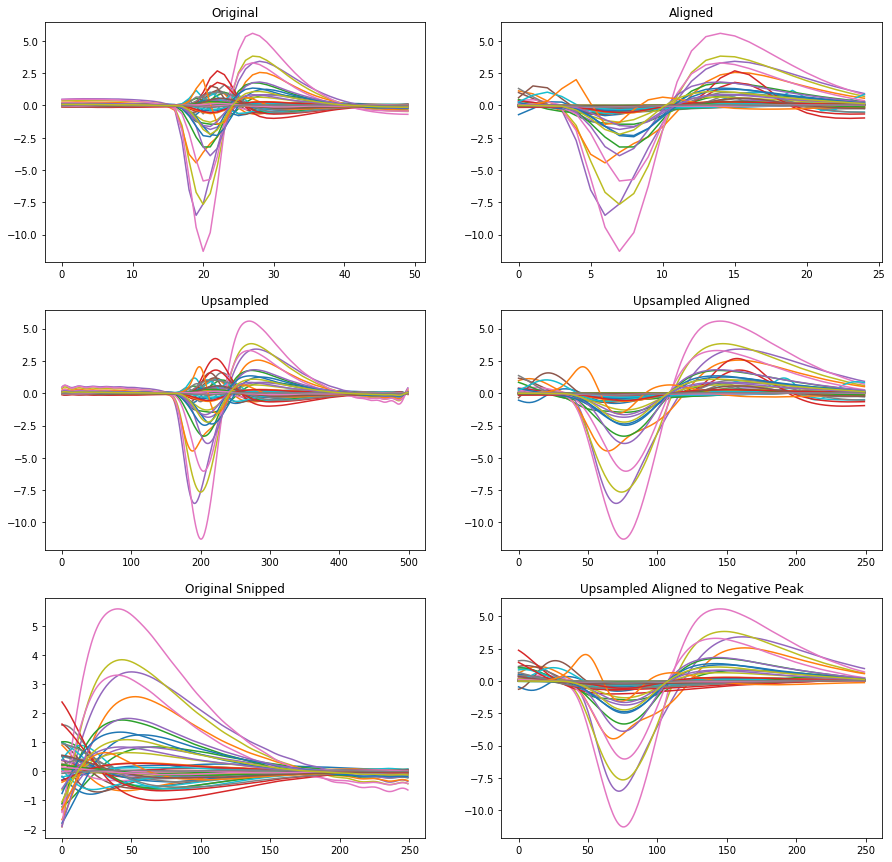

In [7]:
UNIT = 23
UPSAMPLE = 10
ALIGN_WIN_FRAC = 1./2.

temp = mwc.templates[:, :, UNIT]

fig, ax = plt.subplots(3, 2)

# originial
ax[0, 0].plot(temp)
ax[0, 0].set_title('Original')

# aligned
align_win = int(ALIGN_WIN_FRAC * temp.shape[0])
ax[0, 1].plot(align_template(temp, align_win))
ax[0, 1].set_title('Aligned')

# upsampled
up_temp = sp.signal.resample(temp, UPSAMPLE * temp.shape[0])
ax[1, 0].plot(up_temp)
ax[1, 0].set_title('Upsampled')

# upsampled aligned
ax[1, 1].plot(align_template(
    up_temp, UPSAMPLE * align_win))
ax[1, 1].set_title('Upsampled Aligned')

# upsampled aligned
ax[2, 0].plot(up_temp[230:230+UPSAMPLE * align_win, :])
ax[2, 0].set_title('Original Snipped')

# upsampled aligned
ax[2, 1].plot(align_template(
    up_temp, UPSAMPLE * align_win, mode='neg'))
ax[2, 1].set_title('Upsampled Aligned to Negative Peak')


fig.set_size_inches(15, 15)

100%|██████████| 49/49 [00:07<00:00,  6.51it/s]


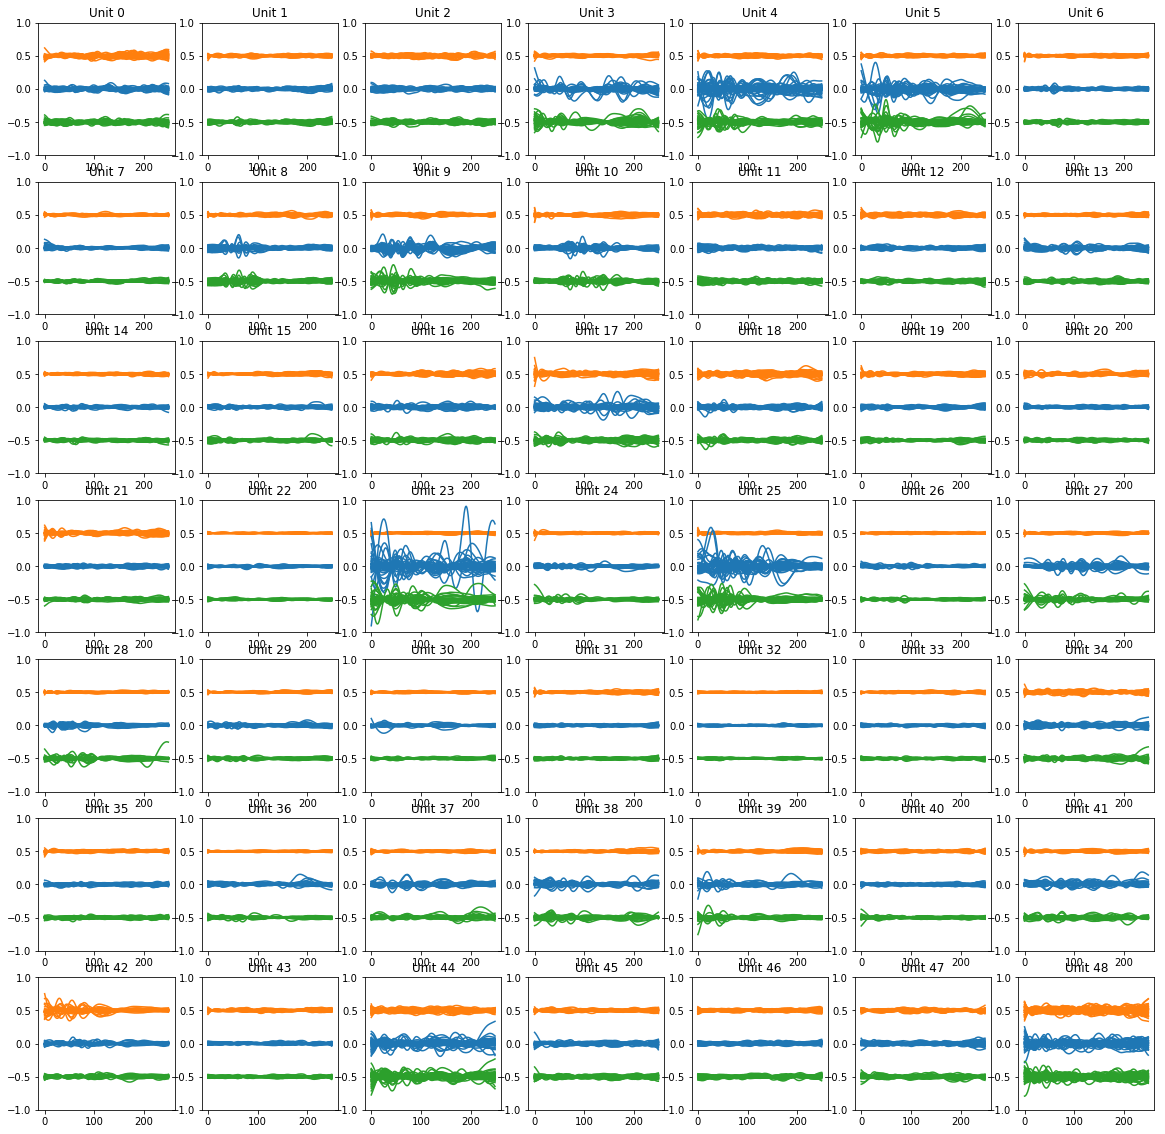

In [8]:
RANK = 5
fig, ax = plt.subplots(7, 7)
for u in tqdm(range(mwc.templates.shape[2])):
    up_win = UPSAMPLE * mwc.templates.shape[0]
    al_win = int(ALIGN_WIN_FRAC * up_win)
    temp = mwc.templates[:, :, u]
    up_temp = sp.signal.resample(temp, up_win)
    al_temp = align_template(up_temp, al_win)
    al_temp_neg = align_template(up_temp, al_win, mode='neg')
    ax[u // 7, u % 7].set_ylim(-1, 1)
    up_temp = up_temp[230:230+al_win, :]
    ax[u // 7, u % 7].plot(up_temp - recon(up_temp, rank=RANK) + 0.5, color='C1')
    ax[u // 7, u % 7].plot(al_temp - recon(al_temp, rank=RANK), color='C0')
    ax[u // 7, u % 7].plot(al_temp_neg - recon(al_temp_neg, rank=RANK) - 0.5, color='C2')
    #ax[u % 7, u // 7].plot(temp * .2, color='C2', lw=0.5)
    ax[u // 7, u % 7].set_title('Unit {}'.format(u))

fig.tight_layout()
fig.set_size_inches(20, 20)

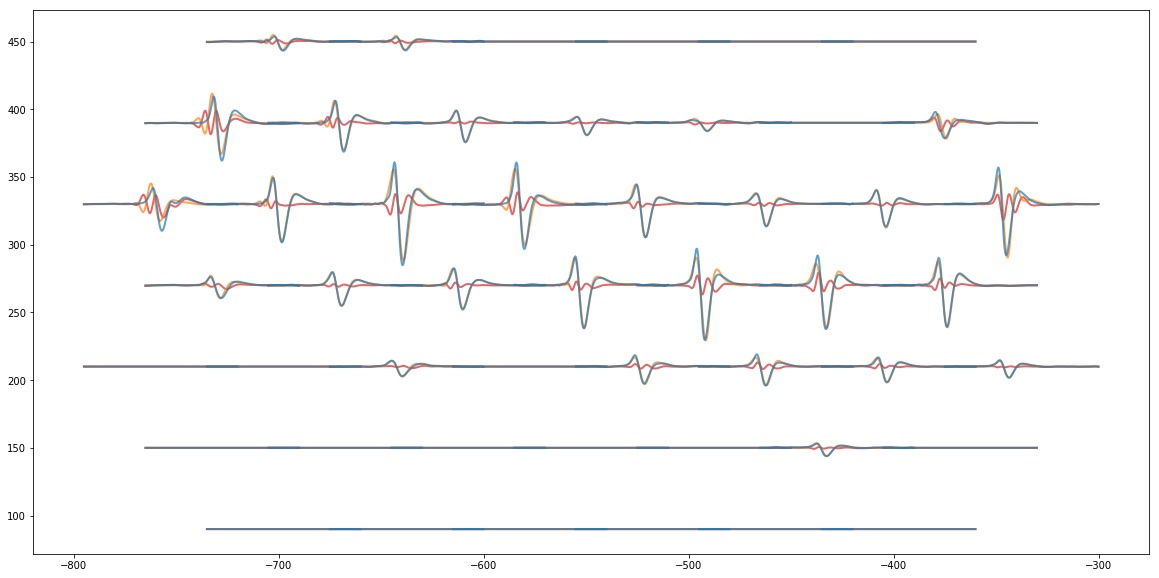

In [10]:
#%matplotlib inline
#import mpld3
#mpld3.disable_notebook()

unit = 10
RANK = 3

geometry = parse(geom, 49)

temp = copy.copy(mwc.templates[:, :, unit])
temp = sp.signal.resample(temp, 60 * 20)
temp[:, main_channels(temp)[:20]] = 0

scale = 10.
squeeze = 16.

fig, ax = plt.subplots()
plot_spatial(geometry, temp-recon(temp, rank=RANK), ax, color='C3', scale=scale, squeeze=squeeze)
plot_spatial(geometry, recon(temp, rank=RANK), ax, color='C1', scale=scale, squeeze=squeeze)
plot_spatial(geometry, temp, ax, color='C0', scale=scale, squeeze=squeeze)

fig.set_size_inches(20, 10)


# Optimal Alignment

# SVD Optimal Alignment

In [6]:
UNIT = 0

temp = mwc.templates[:, :, UNIT]
temp = temp[:, vis_chan(temp)]

new_temp, l = optimal_aligned_compress(temp)

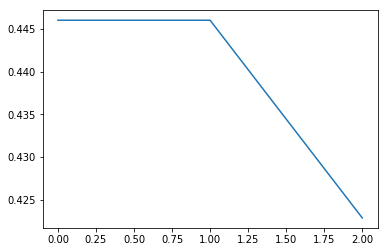

In [7]:
plt.plot(l)

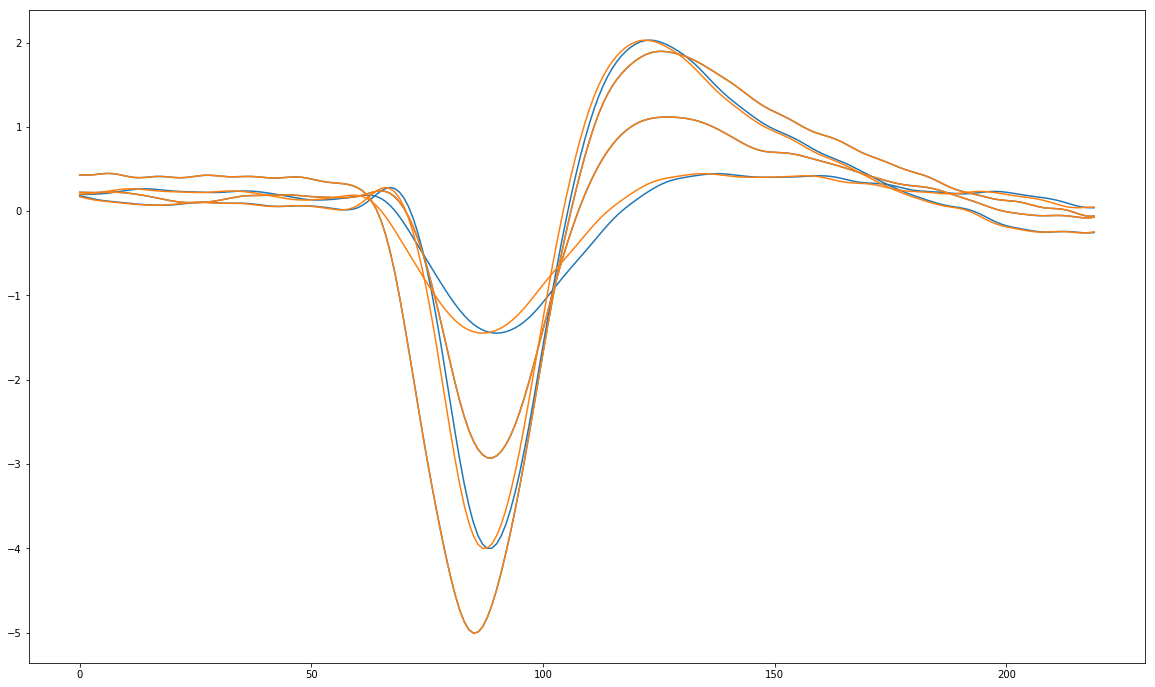

In [8]:
import matplotlib
fig, ax = plt.subplots()
ax.plot(sp.signal.resample(temp, temp.shape[0] * 5)[15:-15, :], color='C0')
ax.plot(new_temp, color='C1')
fig.set_size_inches(20, 12)

# Liam's  SVD Optimal Alignment

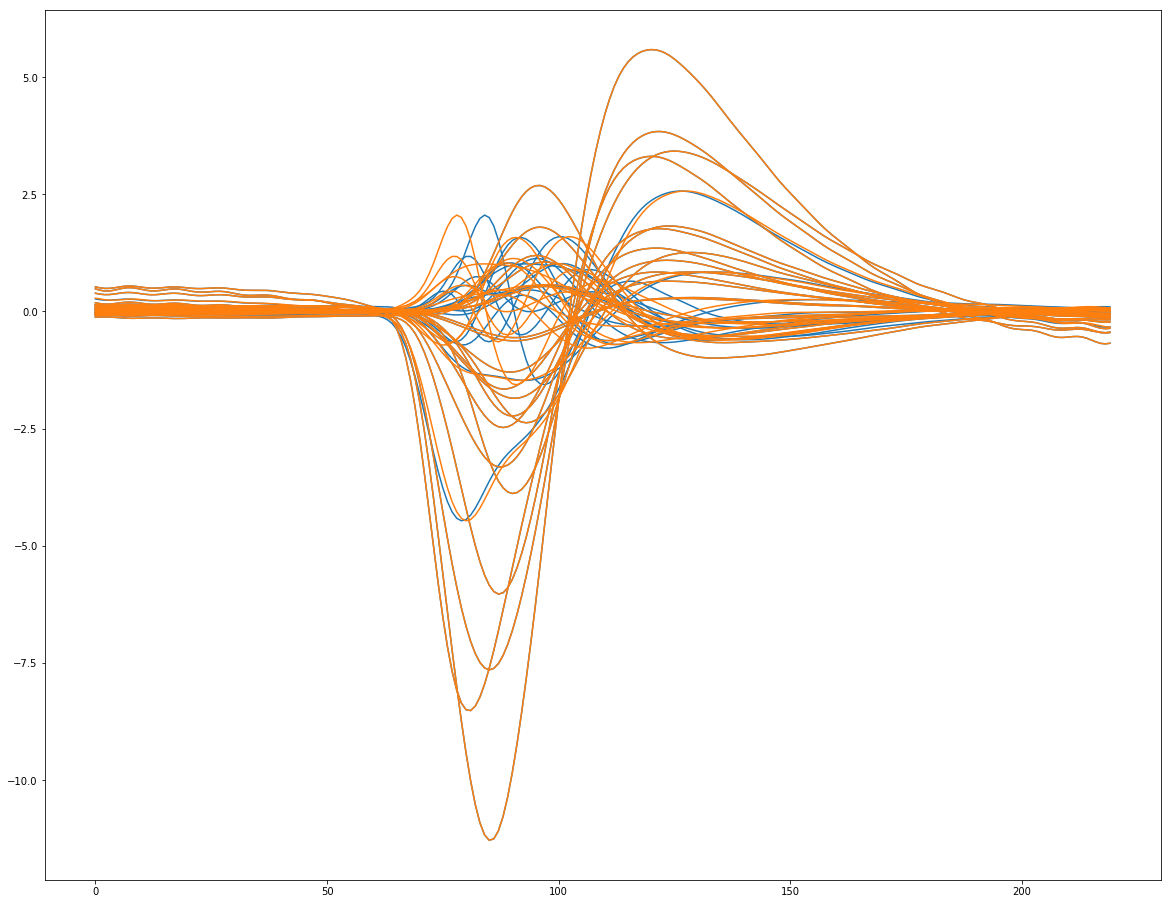

In [9]:
UNIT = 23

geometry = parse(geom, 49)
temp = mwc.templates[:, :, UNIT]
g = Geometry(geometry[vis_chan(temp), :])
temp = temp[:, vis_chan(temp, min_peak_to_peak=0.7)]



fig, ax = plt.subplots()
ax.plot(sp.signal.resample(temp, temp.shape[0] * 5)[15:-15, :], color='C0')
plt.plot(optimal_svd_align(temp, geometry=g, rank=3, max_shift=6), color='C1')
fig.set_size_inches(20, 16)

# Reconstruction Residuals for Optimal SVD Alignment

100%|██████████| 49/49 [00:48<00:00,  1.01it/s]


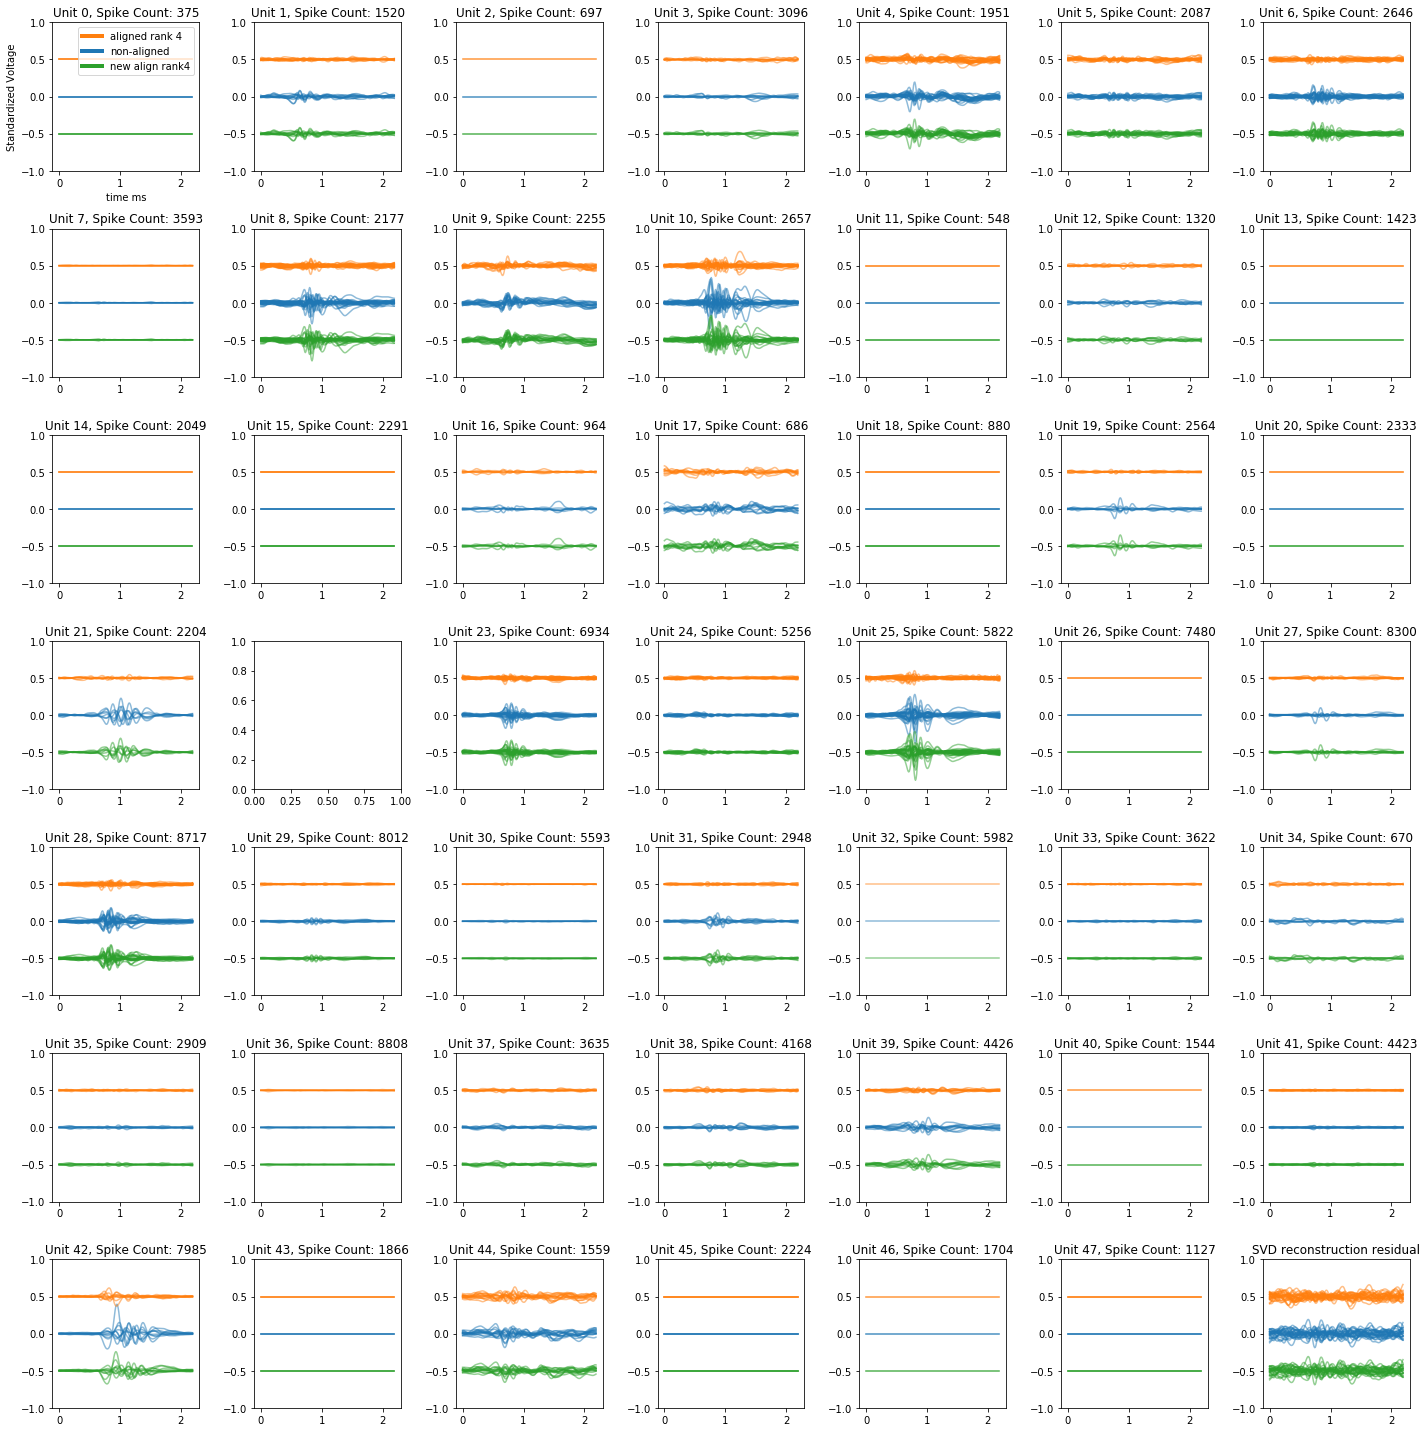

In [11]:

UPSAMPLE = 5
MAX_SHIFT = 6

fig, ax = plt.subplots(7, 7)

ax[0, 0].set_ylabel('Standardized Voltage')
ax[0, 0].set_xlabel('time ms')

for u in tqdm(range(mwc.templates.shape[2])):
    RANK = 5 # Param
    temp = mwc.templates[:, :, u]

    g = Geometry(geometry[vis_chan(temp), :])
    temp = temp[:, vis_chan(temp)]

    if temp.shape[1] < 1:
        continue
    if temp.shape[1] < RANK:
        RANK = temp.shape[1]

    new_temp, l = optimal_aligned_compress(temp, rank=RANK, upsample=UPSAMPLE, max_shift=MAX_SHIFT)
    lial_temp = optimal_svd_align(temp, geometry=g, rank=RANK, upsample=UPSAMPLE, max_shift=MAX_SHIFT)

    crop_off = UPSAMPLE * MAX_SHIFT // 2
    temp = sp.signal.resample(temp, temp.shape[0] * UPSAMPLE)[crop_off:-crop_off]

    ax[u // 7, u % 7].set_ylim(-1, 1)
    ax[u // 7, u % 7].plot(
        np.arange(0, temp.shape[0]) / (20. * UPSAMPLE),
        temp - recon(temp, rank=RANK), color='C0', alpha=0.5)
    ax[u // 7, u % 7].plot(
        np.arange(0, new_temp.shape[0]) / (20. * UPSAMPLE),
        new_temp - recon(new_temp, rank=RANK) + 0.5, color='C1', alpha=0.5)

    ax[u // 7, u % 7].plot(
        np.arange(0, lial_temp.shape[0]) / (20. * UPSAMPLE),
        lial_temp - recon(lial_temp, rank=RANK) - 0.5, color='C2', alpha=0.5)
    
    ax[u // 7, u % 7].set_title('Unit {}, Spike Count: {}'.format(u, np.sum(gold_sp[:, 1] == u)))
    if u == 0:
        custom_lines = [Line2D([0], [0], color='C1', lw=4),
                        Line2D([0], [0], color='C0', lw=4),
                        Line2D([0], [0], color='C2', lw=4)]
        ax[u // 7, u % 7].legend(custom_lines,['aligned rank {}'.format(RANK), 'non-aligned', 'new align rank{}'.format(RANK)])

fig.set_size_inches(20, 20)
fig.tight_layout()
plt.savefig('reconstruction_residual_rank_{}.pdf'.format(RANK))

# SVD Ranks for Alignment vs. Non-Aligend Templates

100%|██████████| 49/49 [01:21<00:00,  1.67s/it]


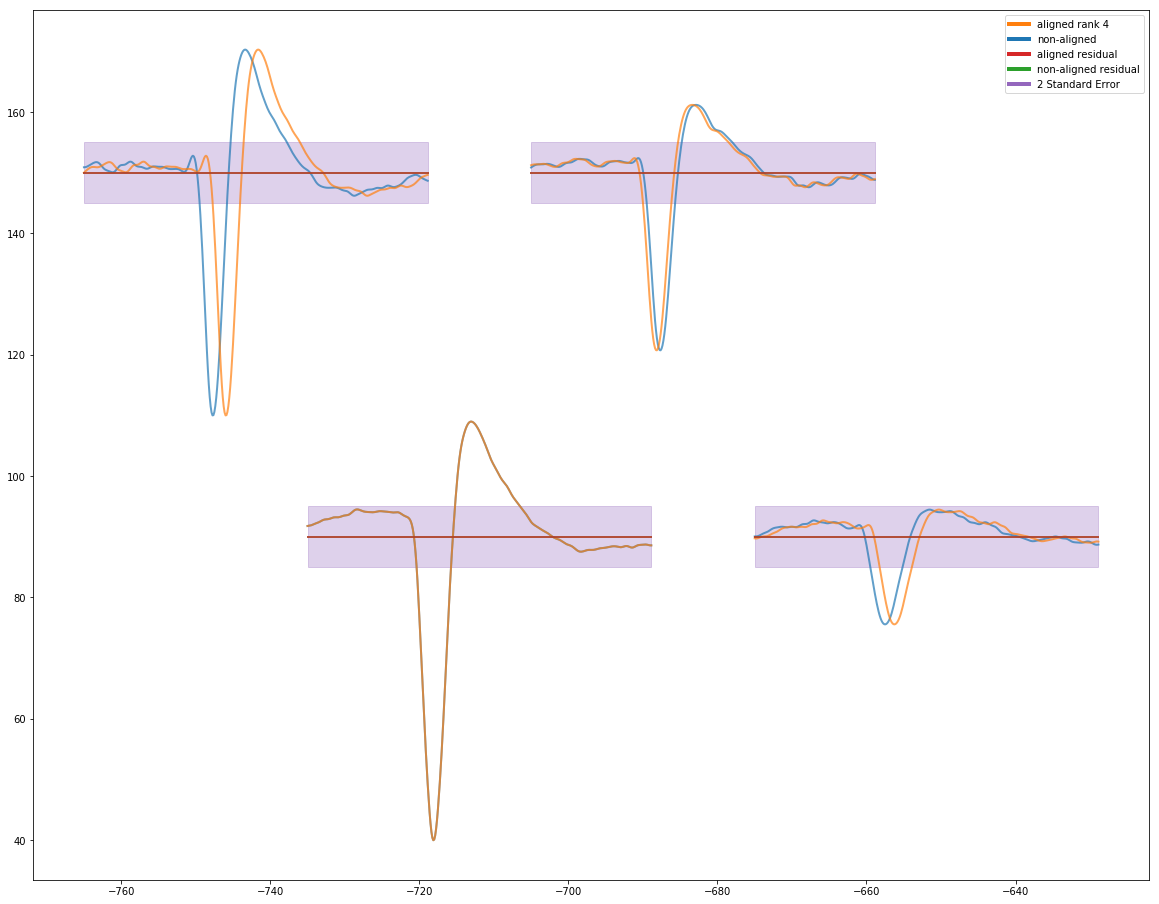

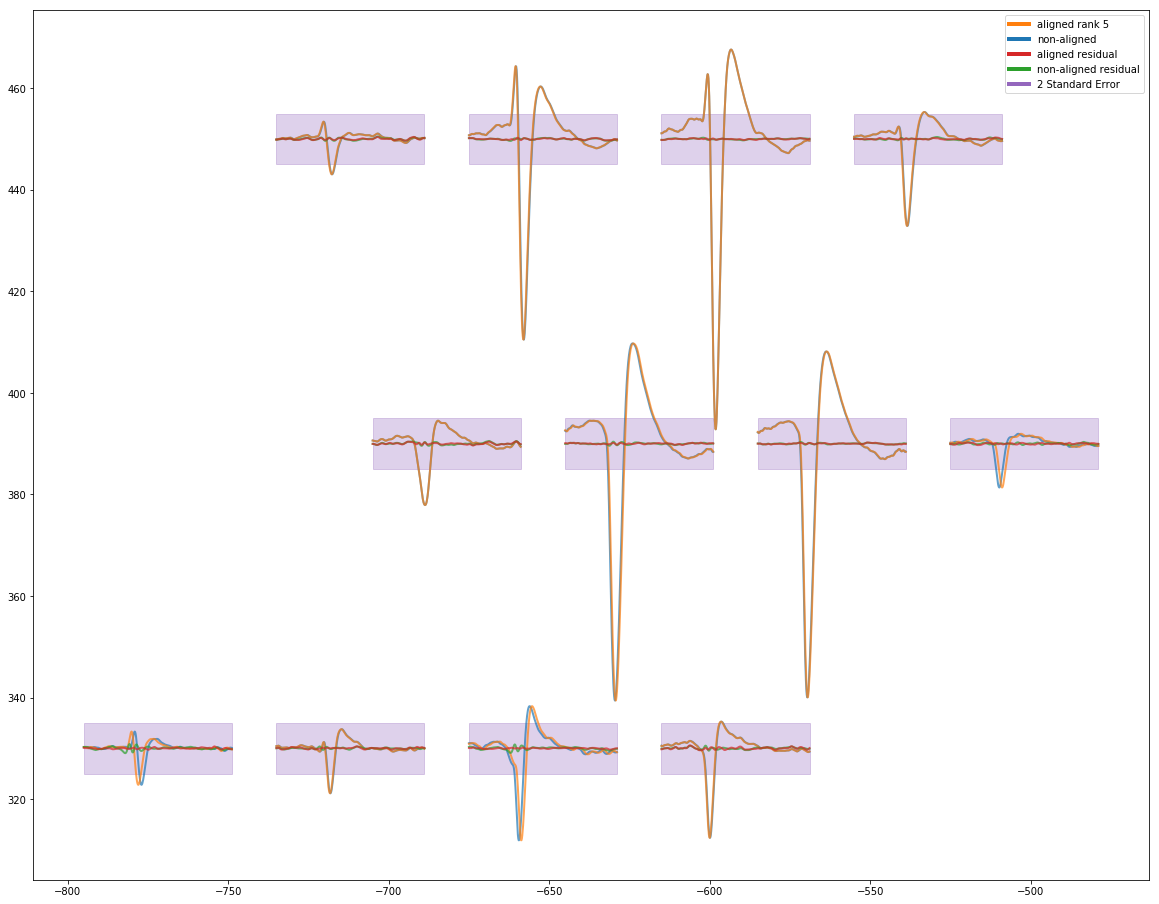

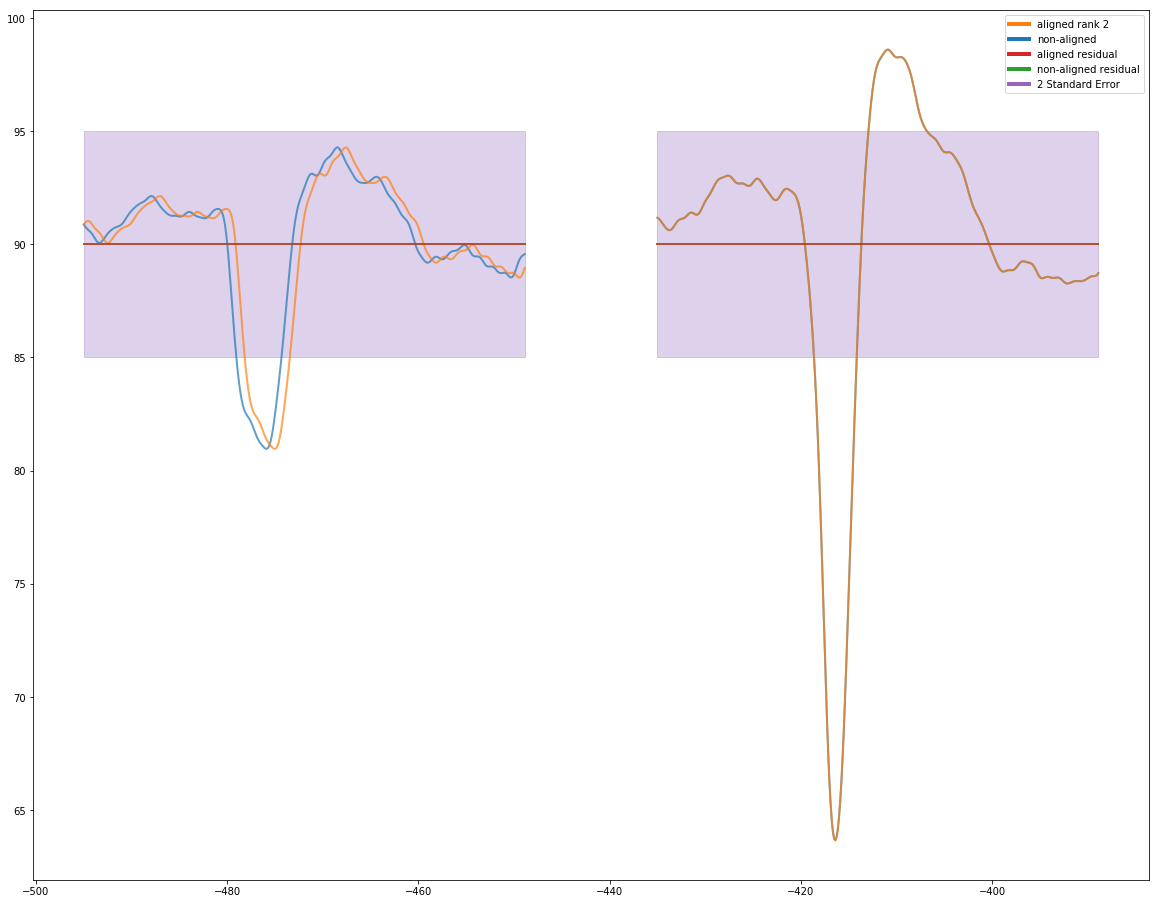

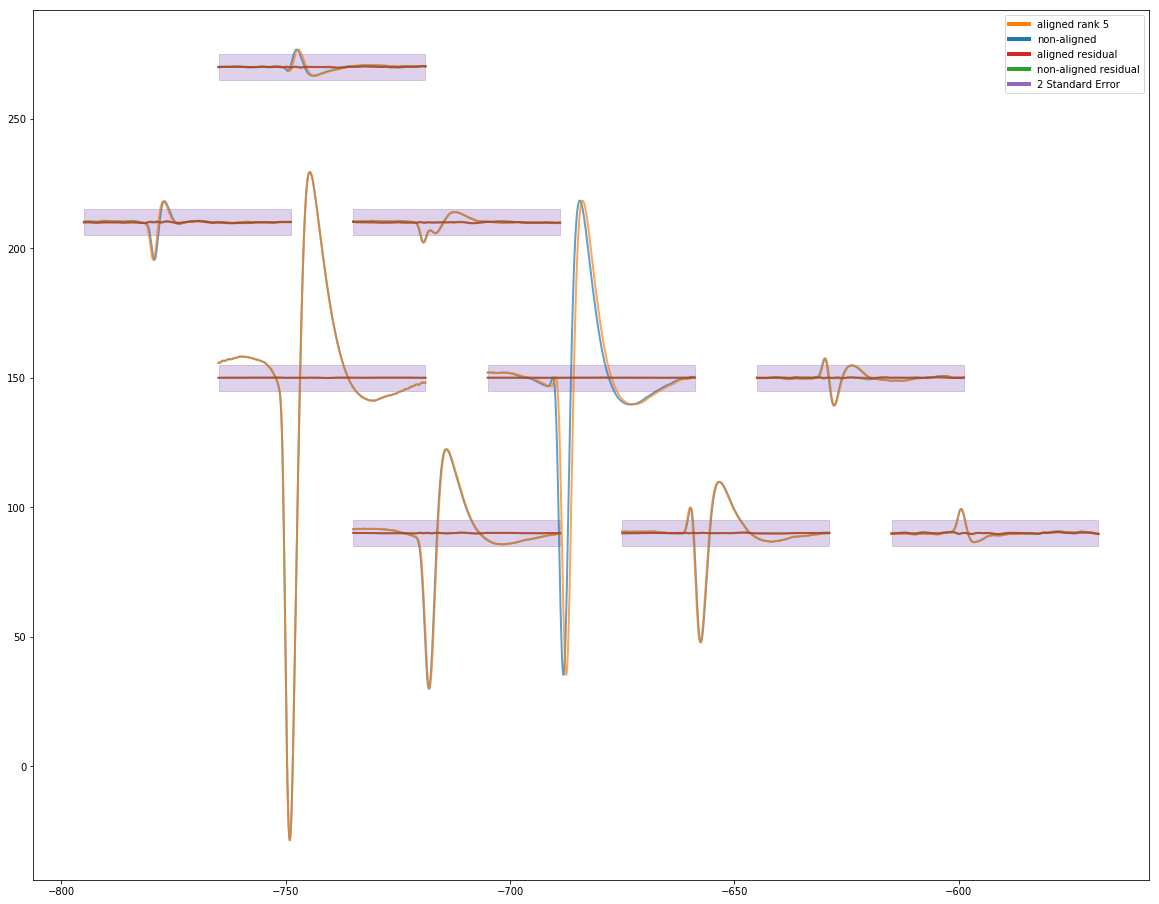

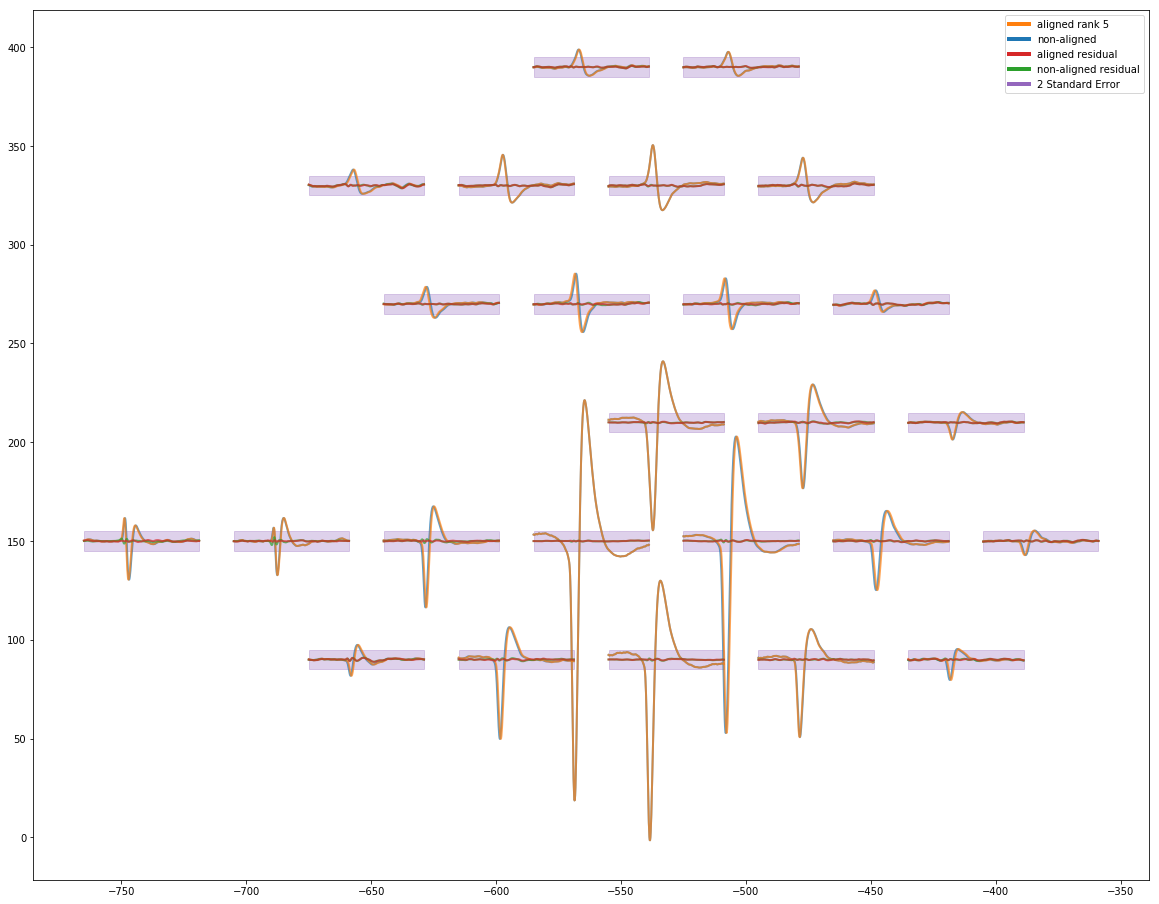

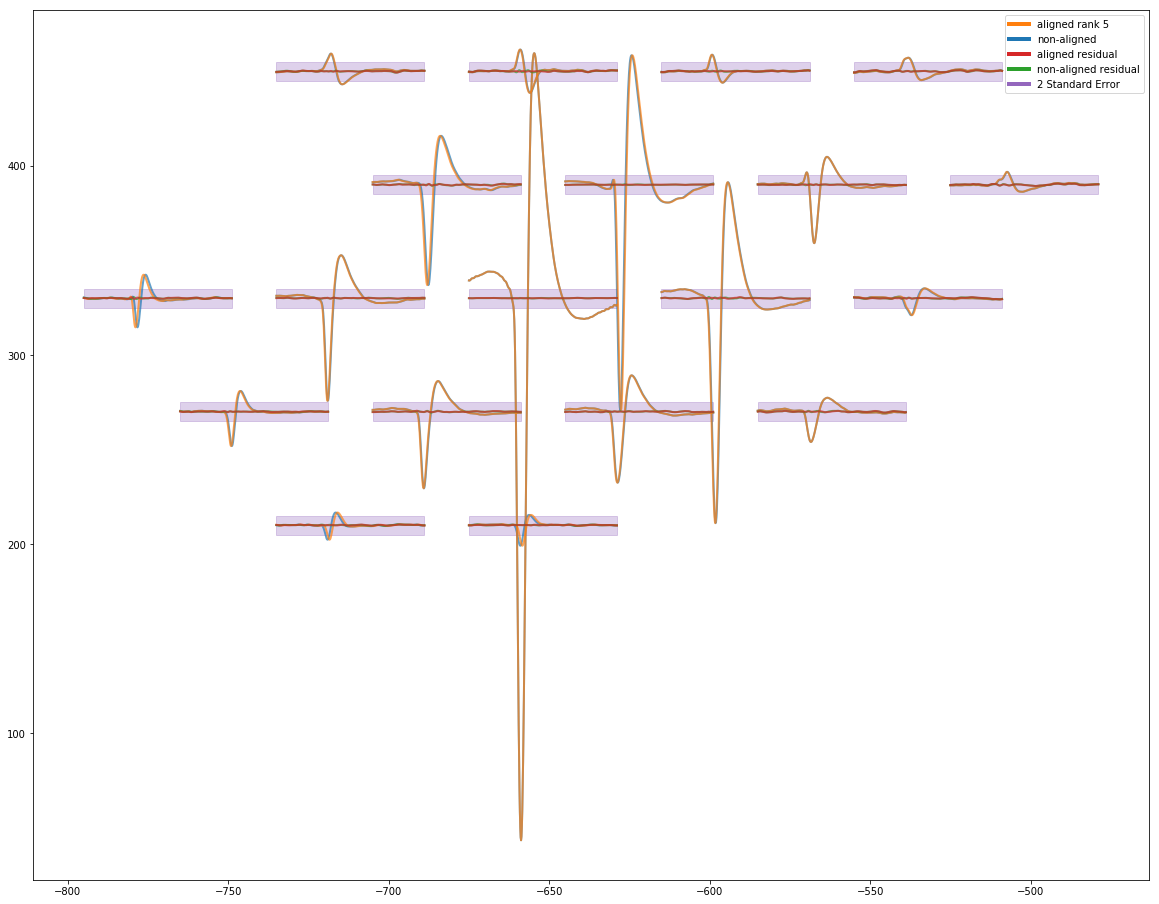

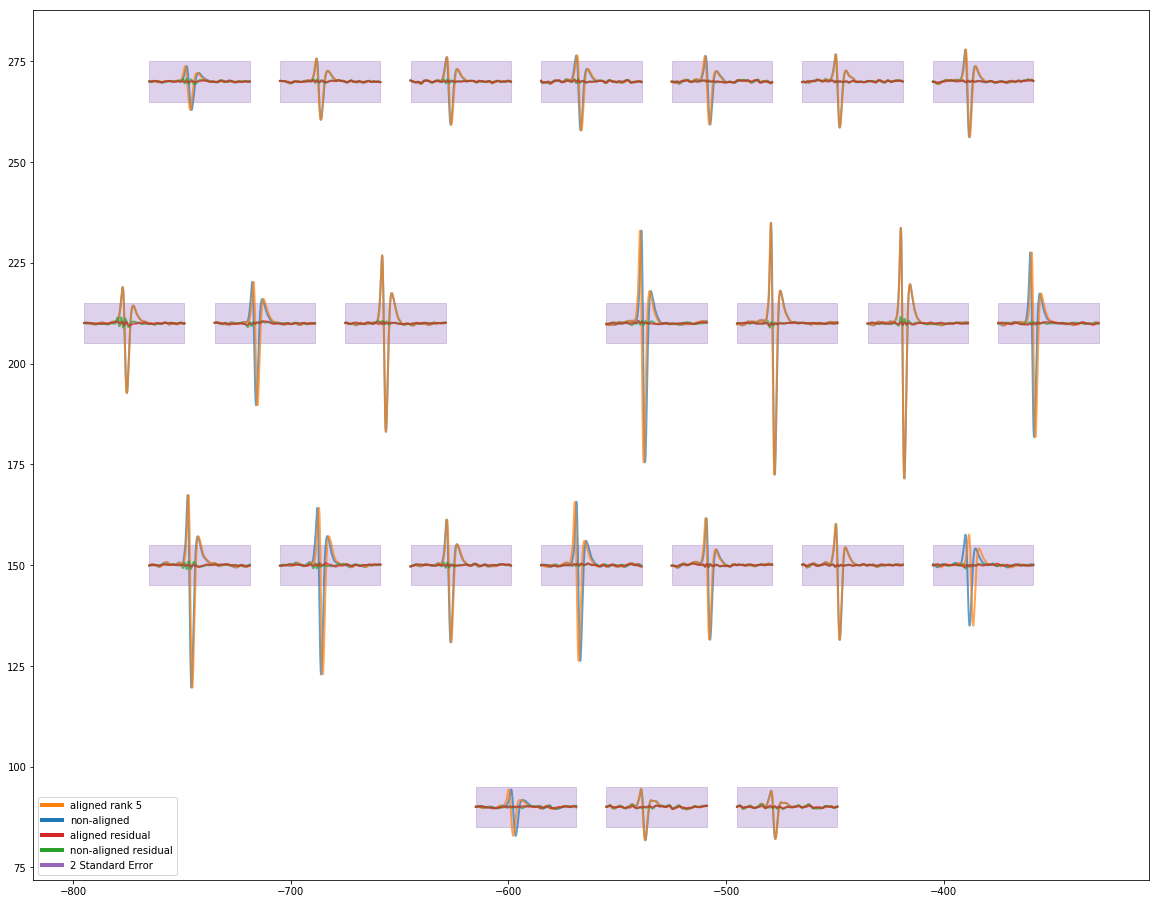

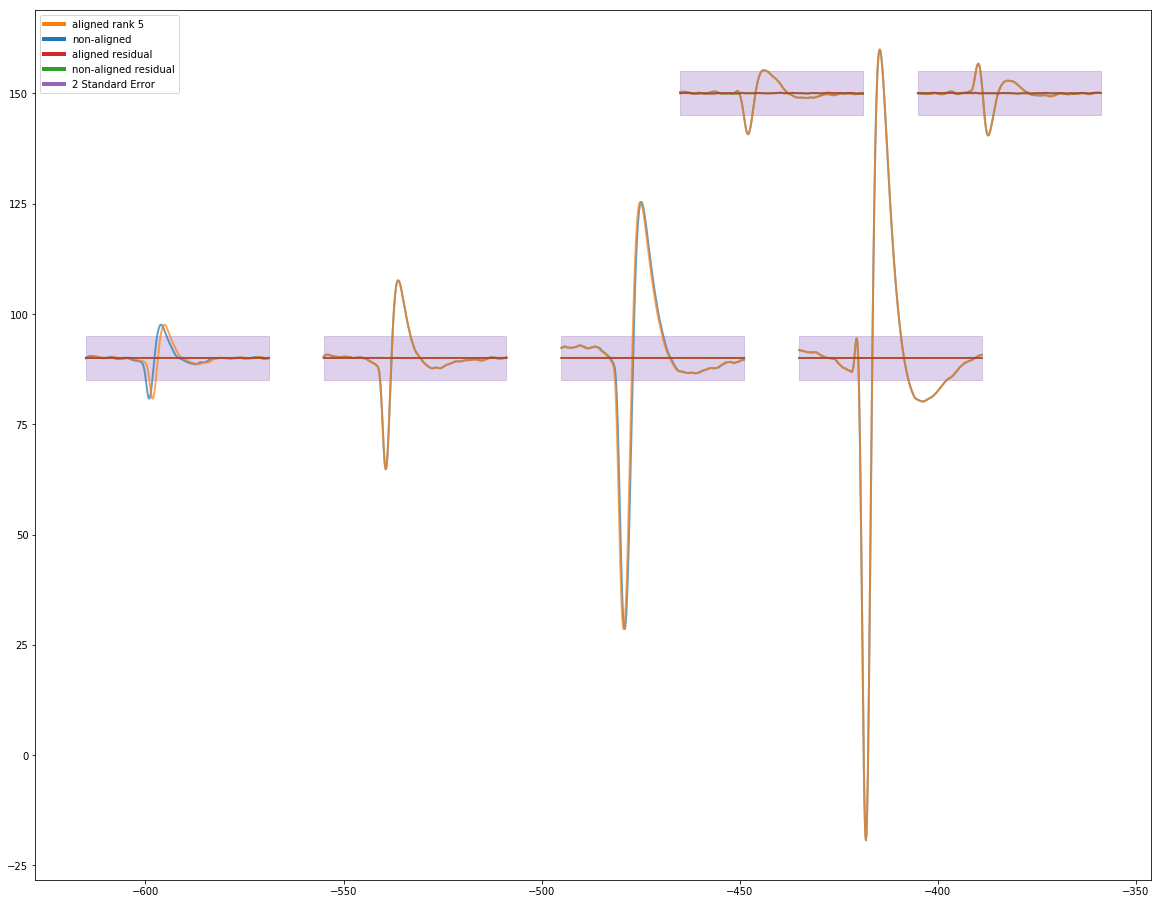

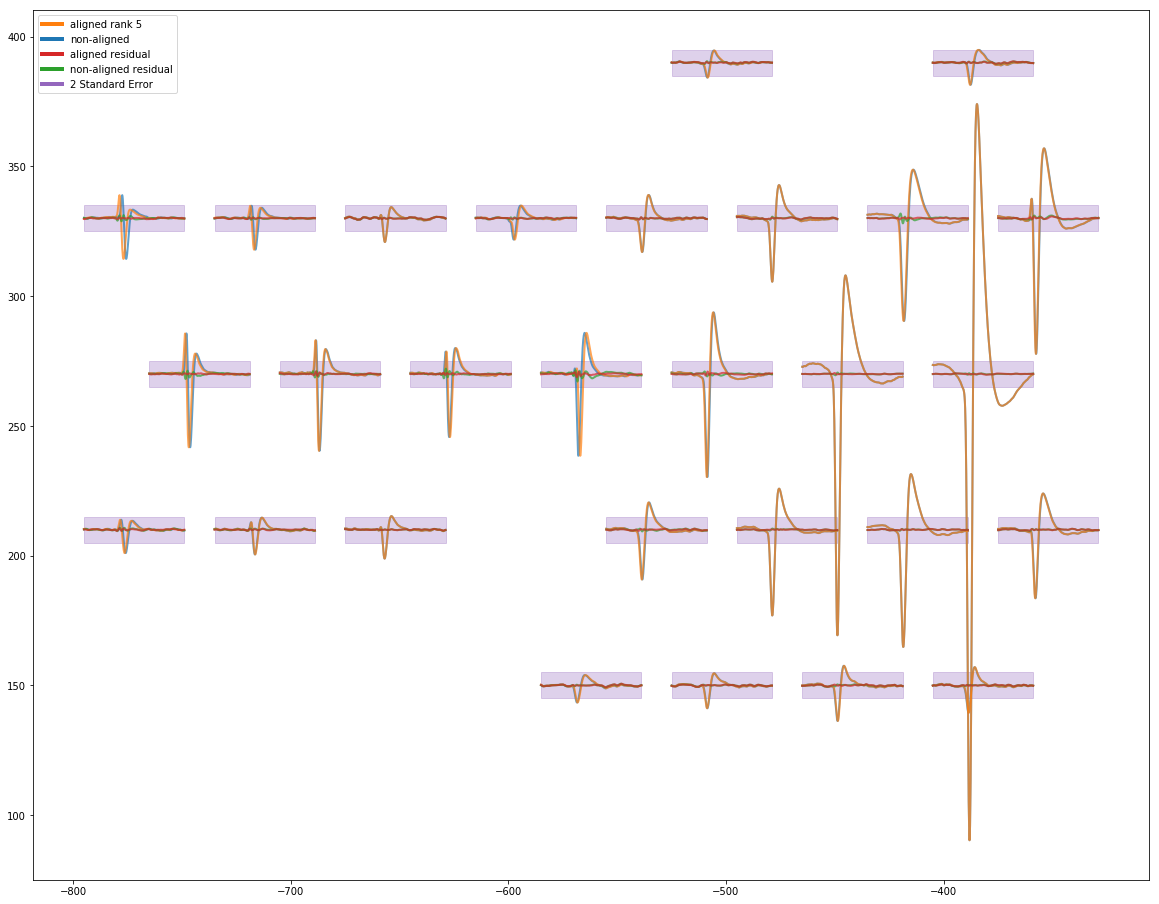

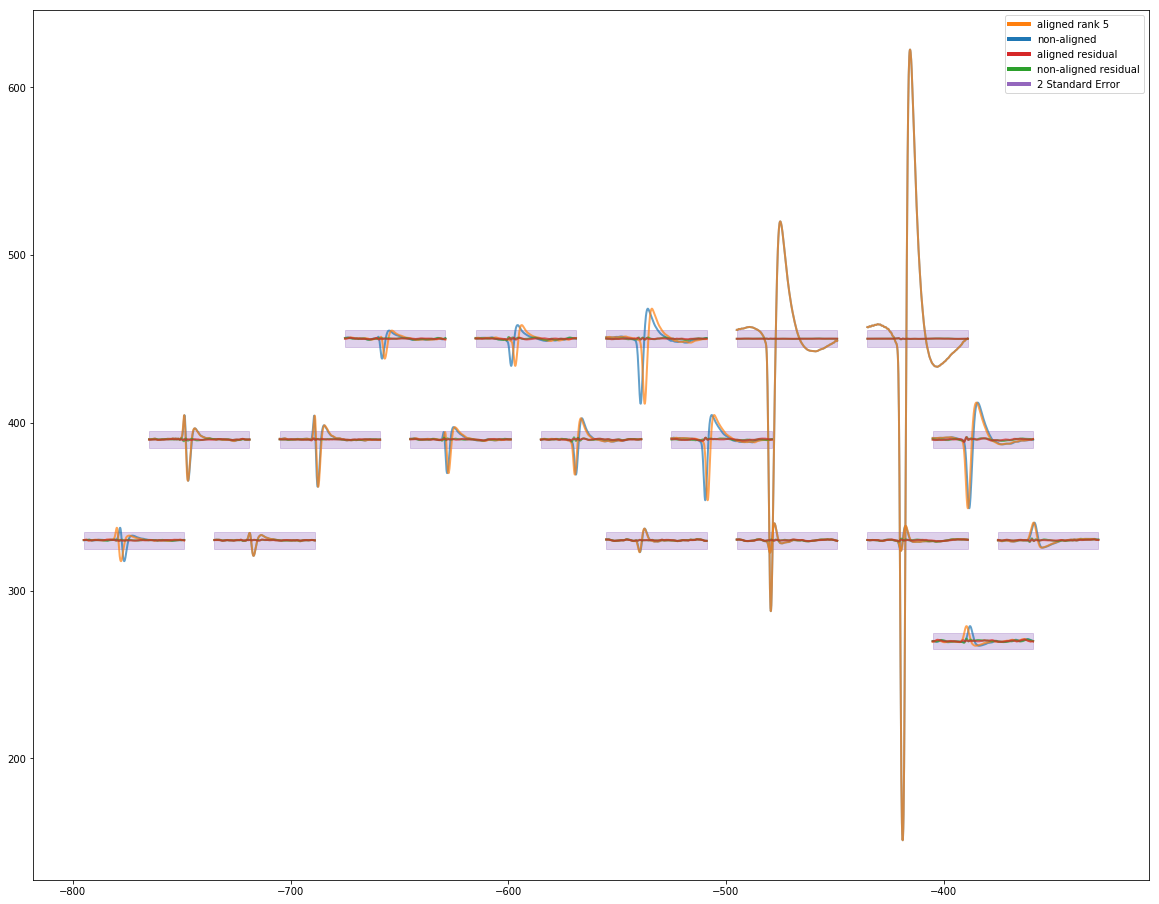

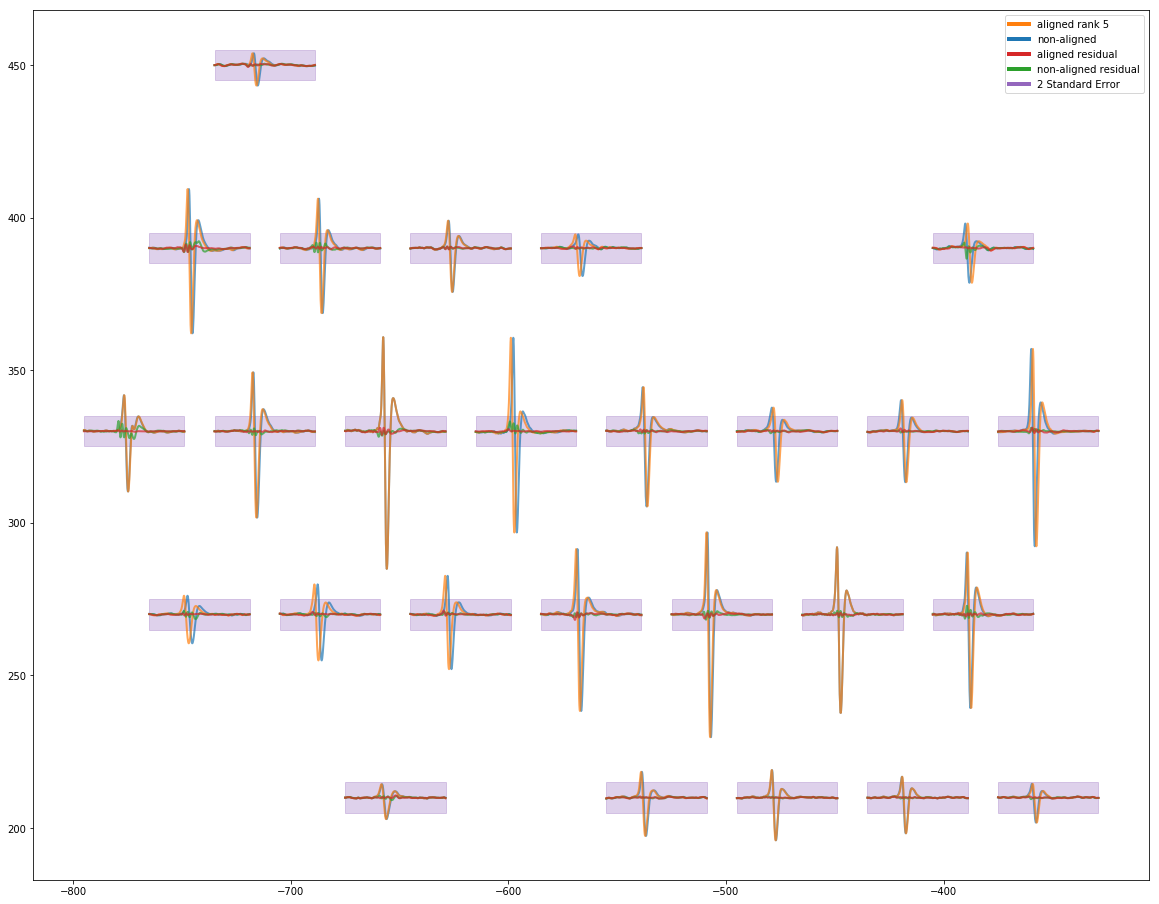

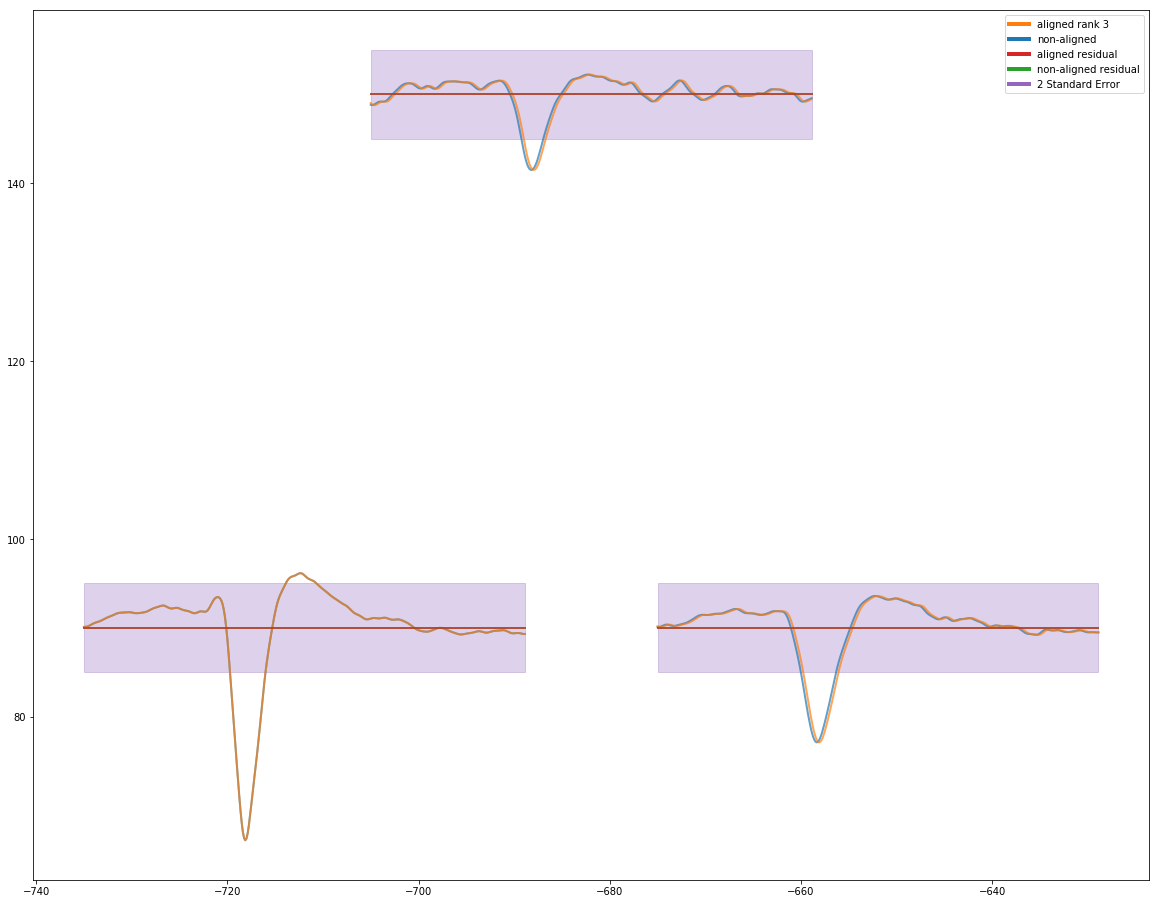

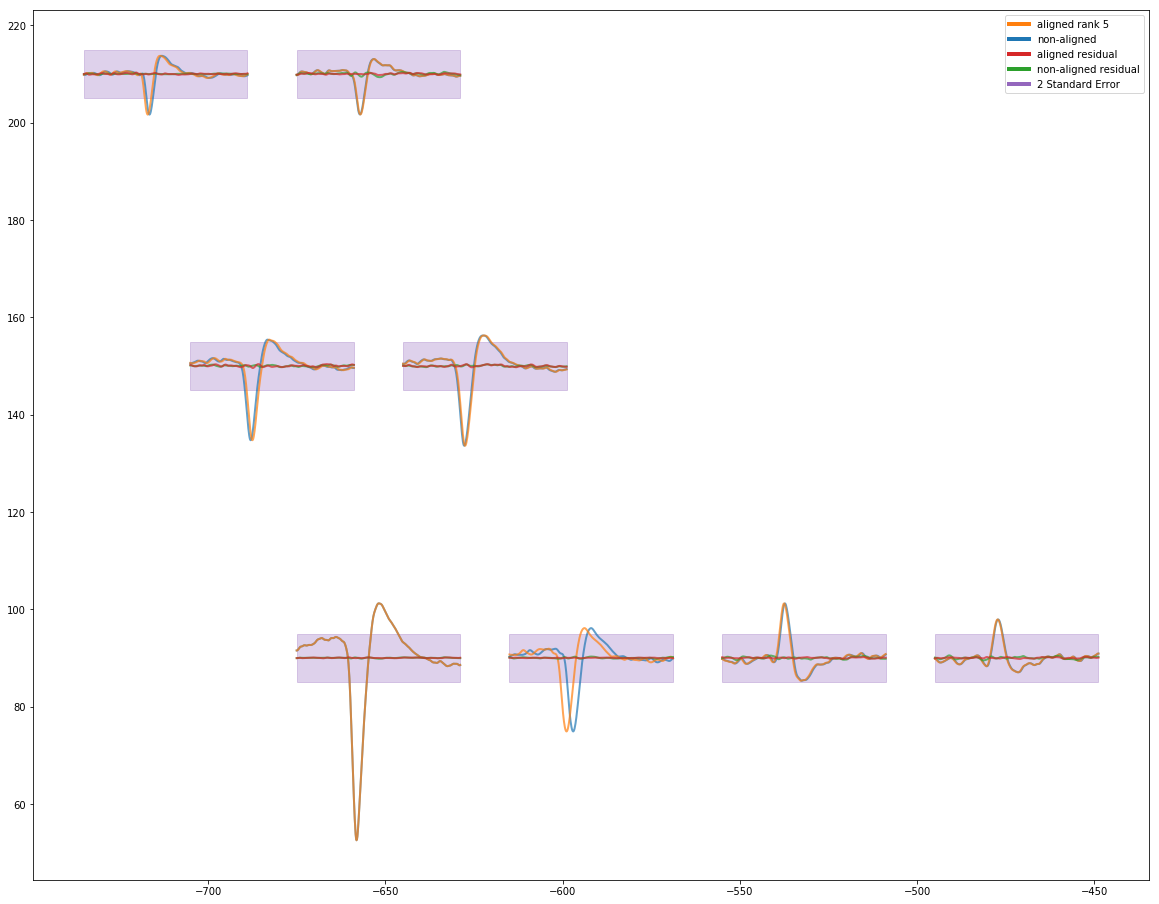

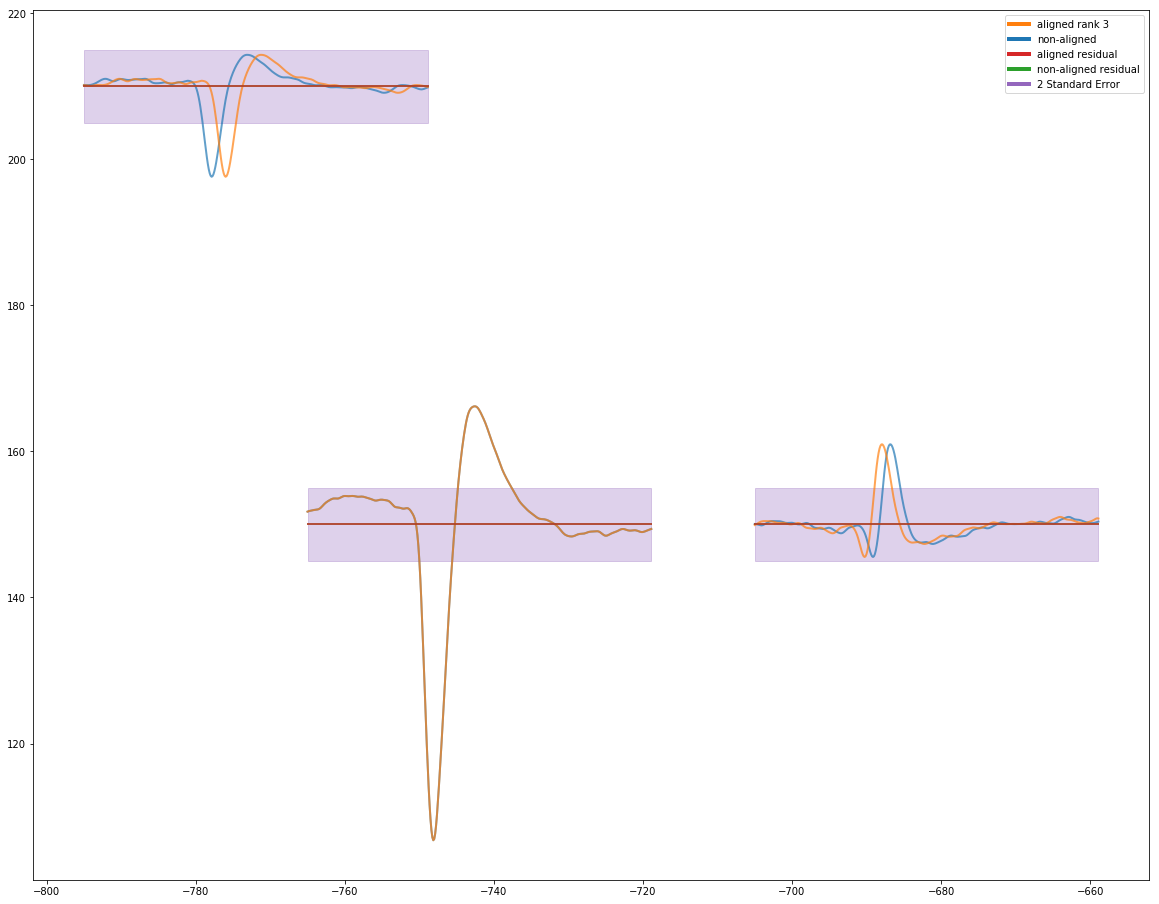

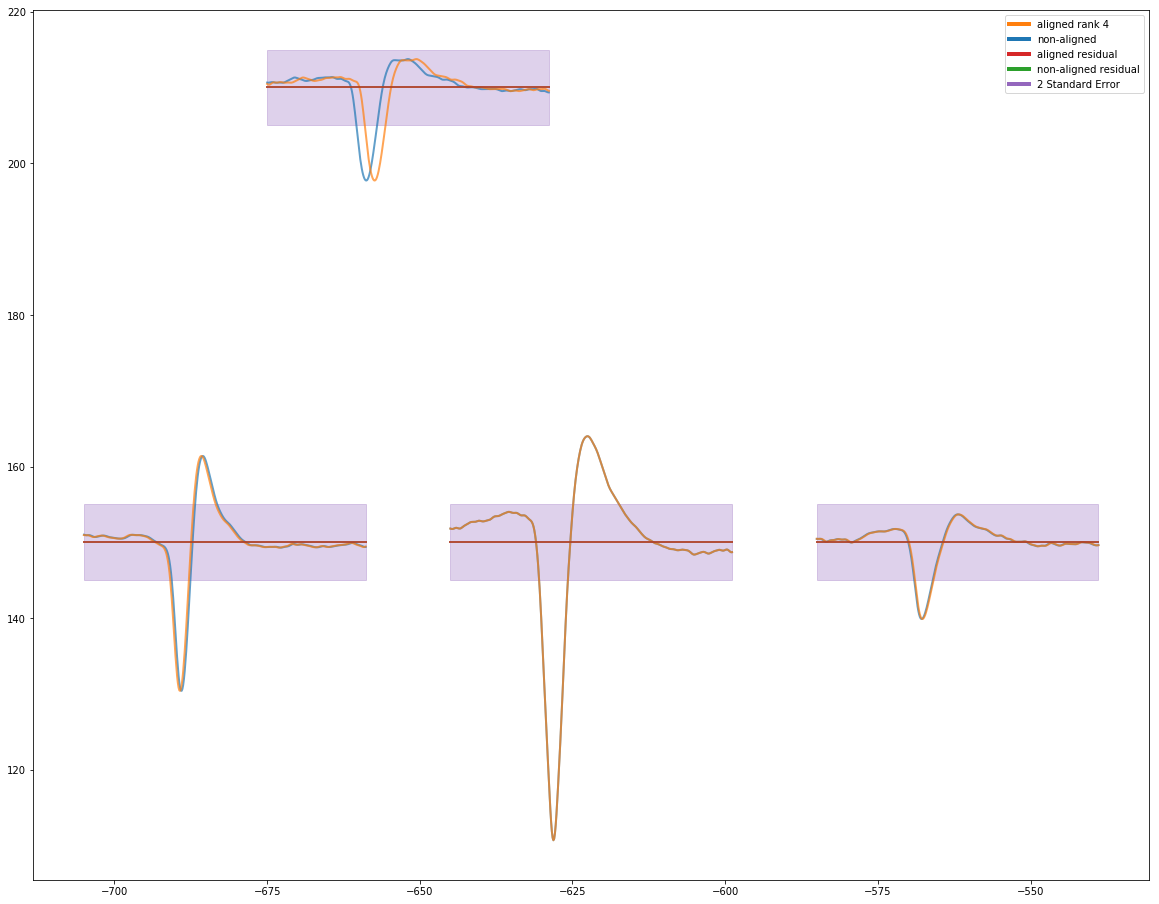

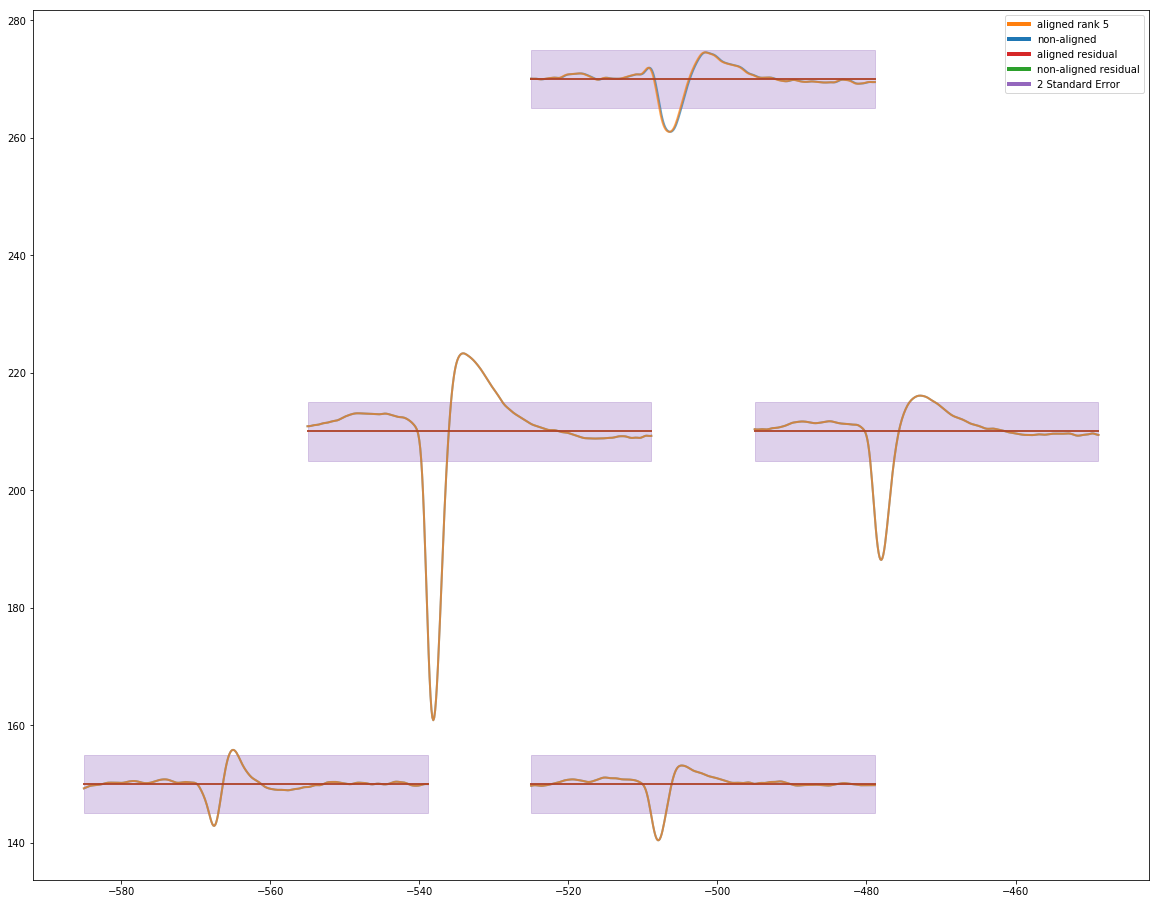

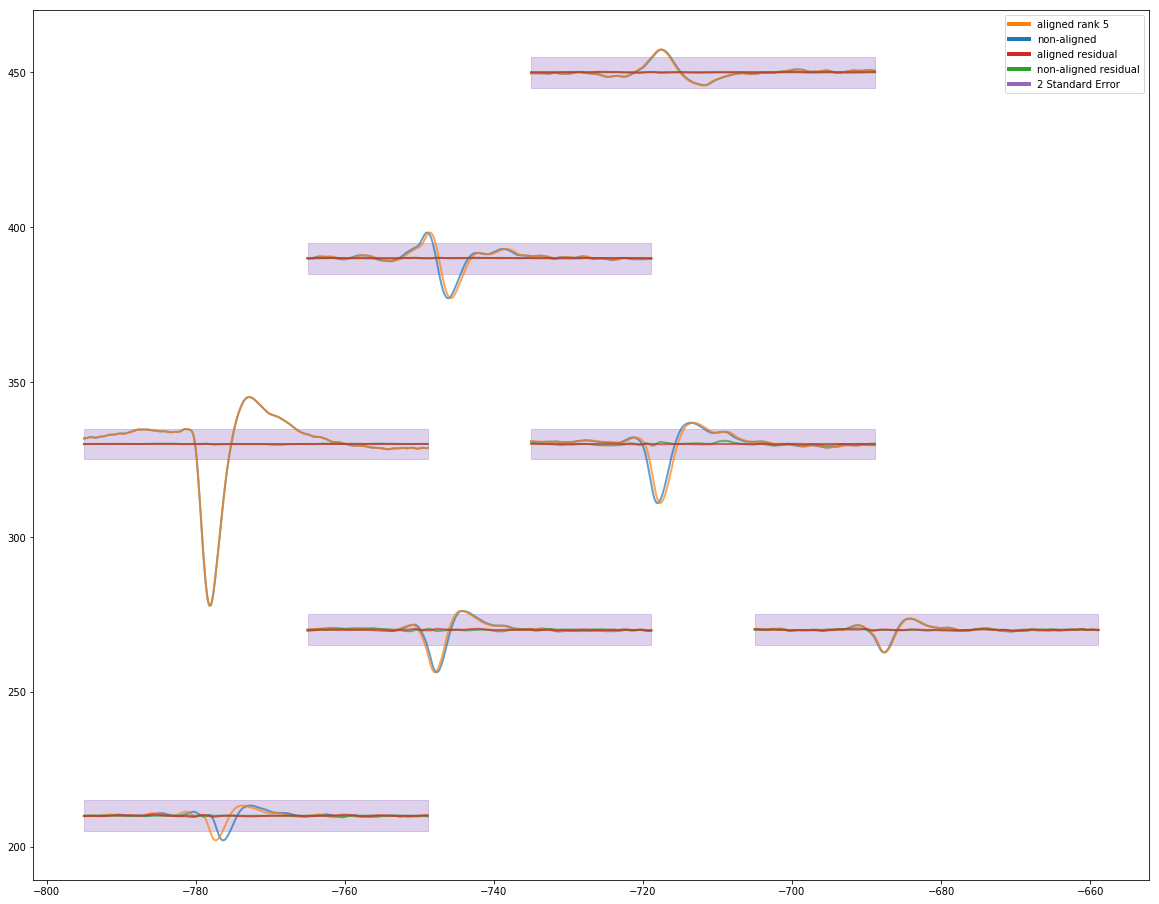

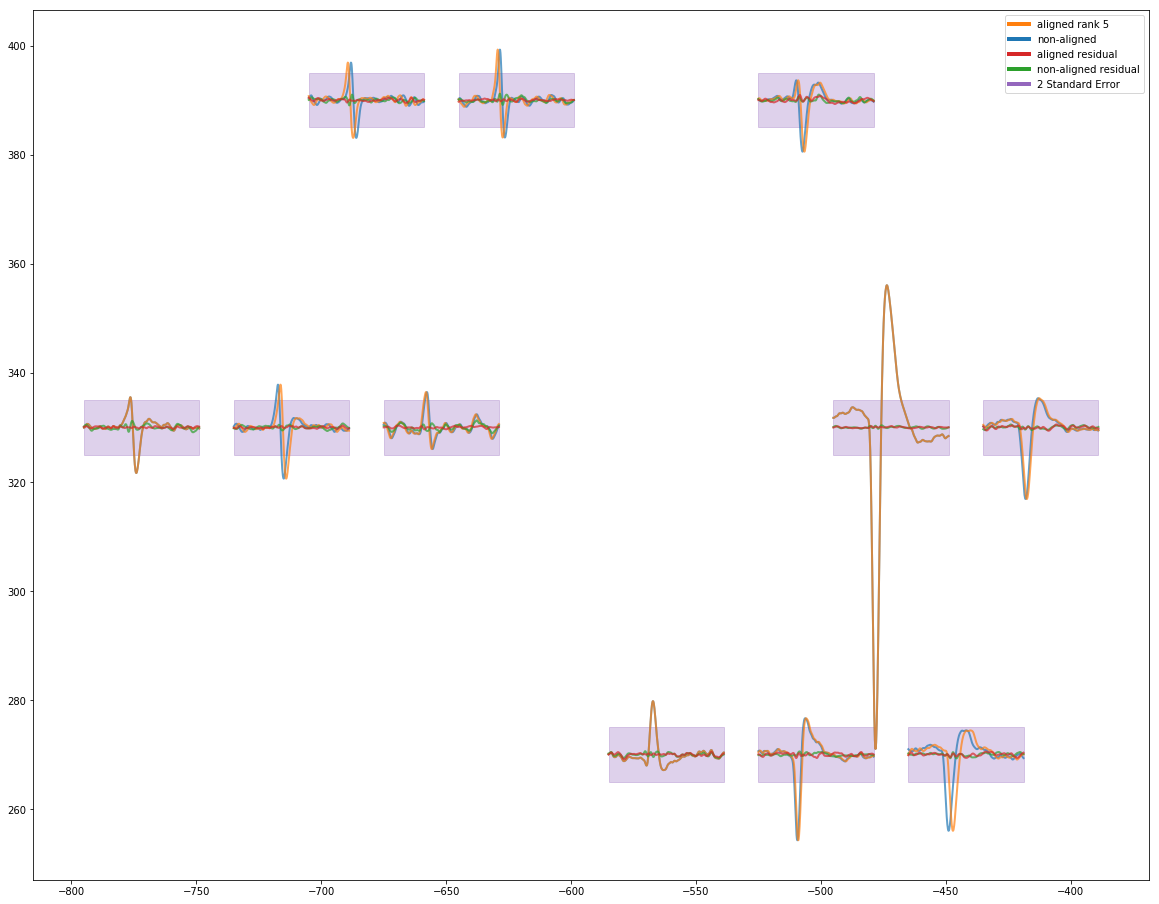

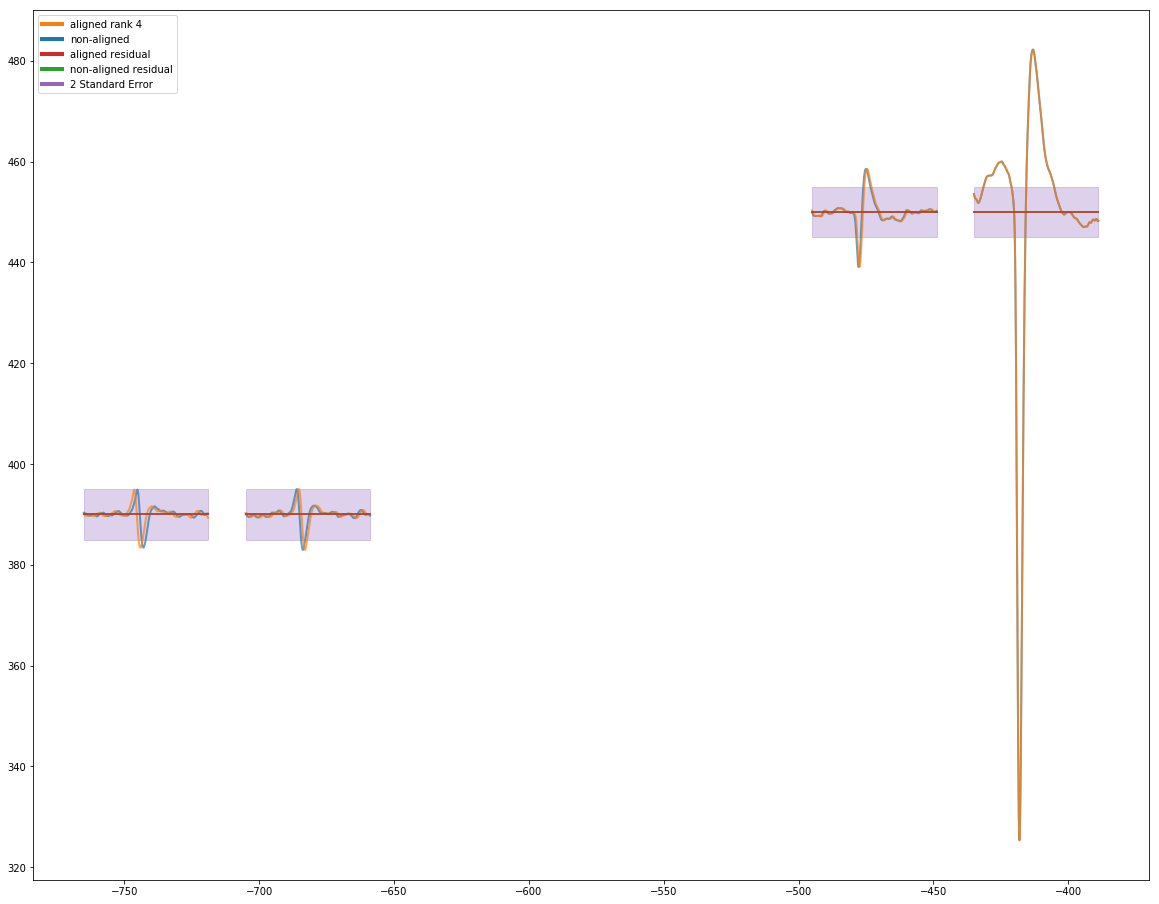

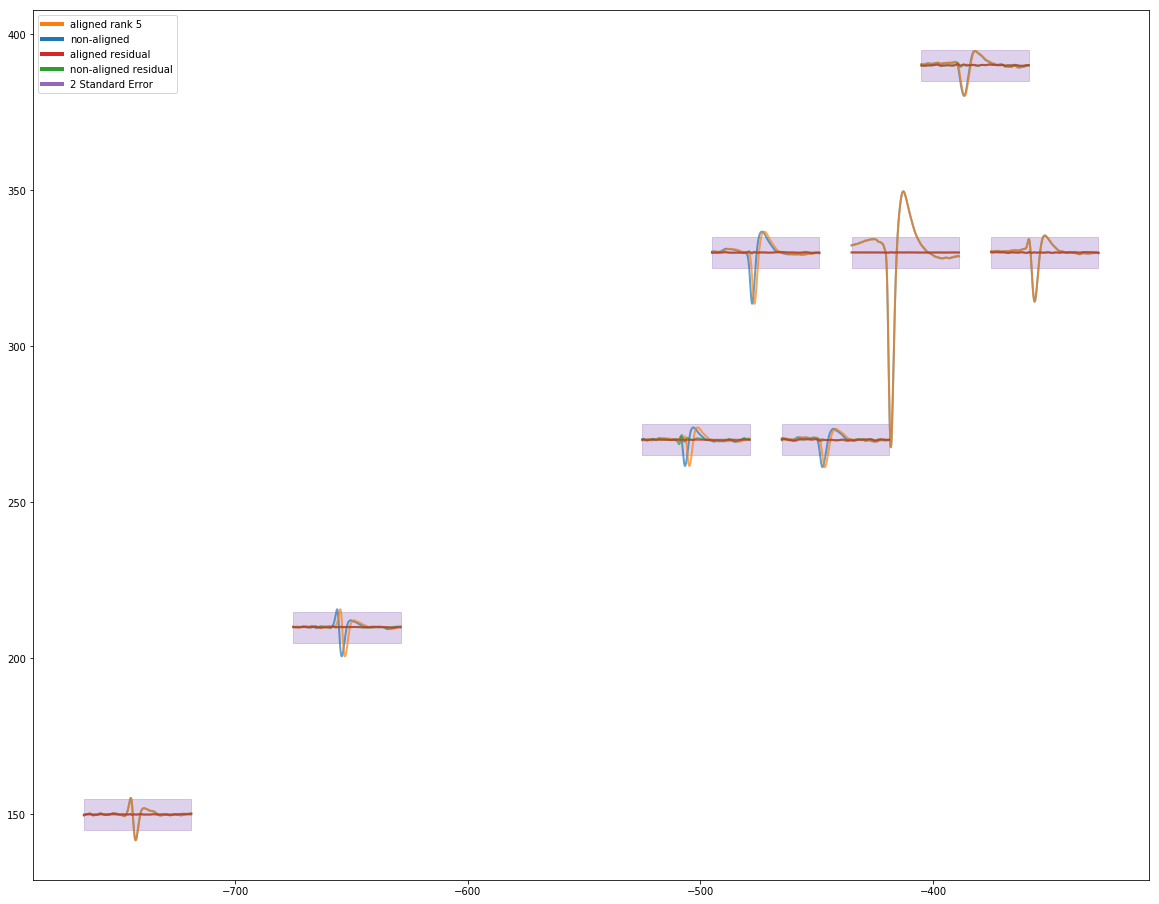

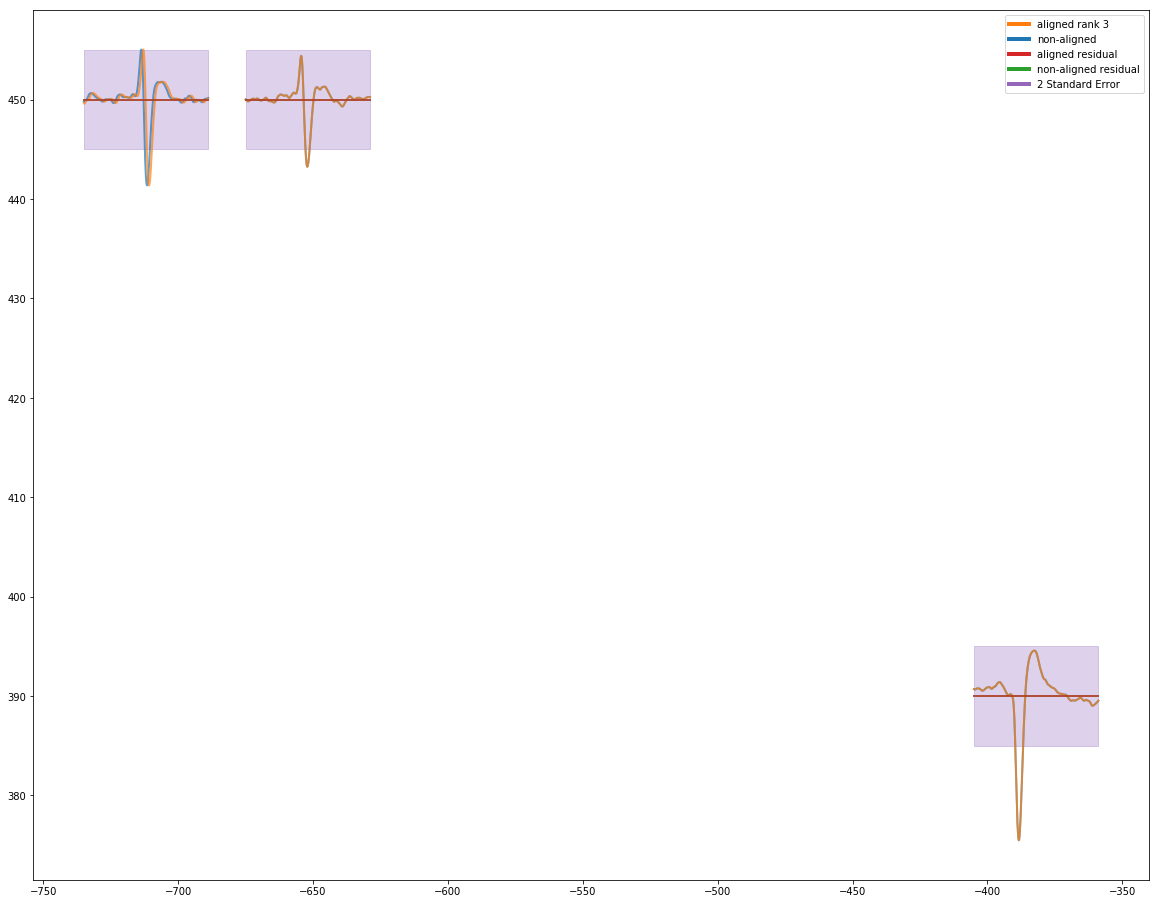

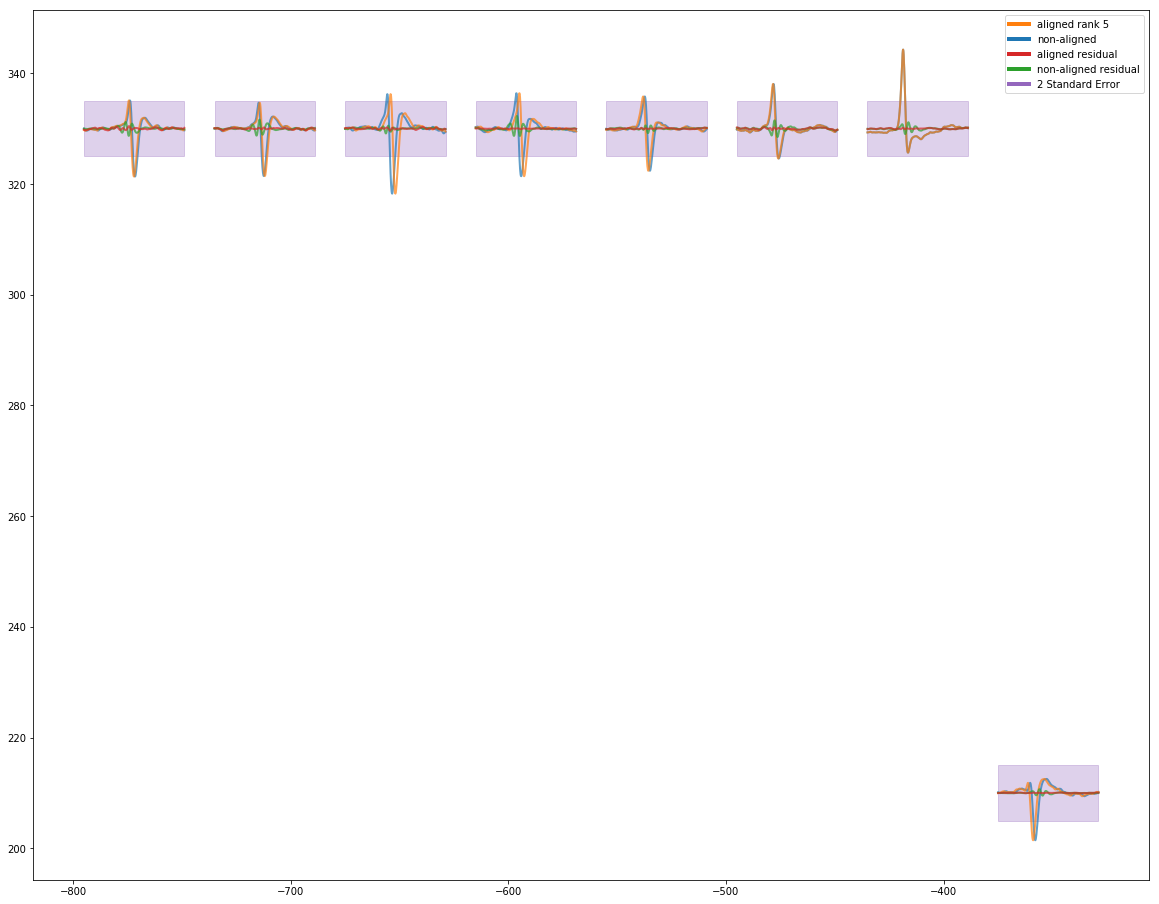

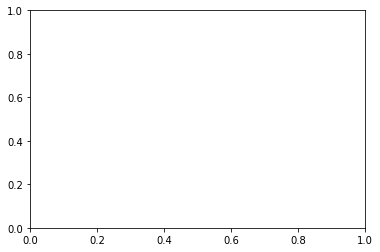

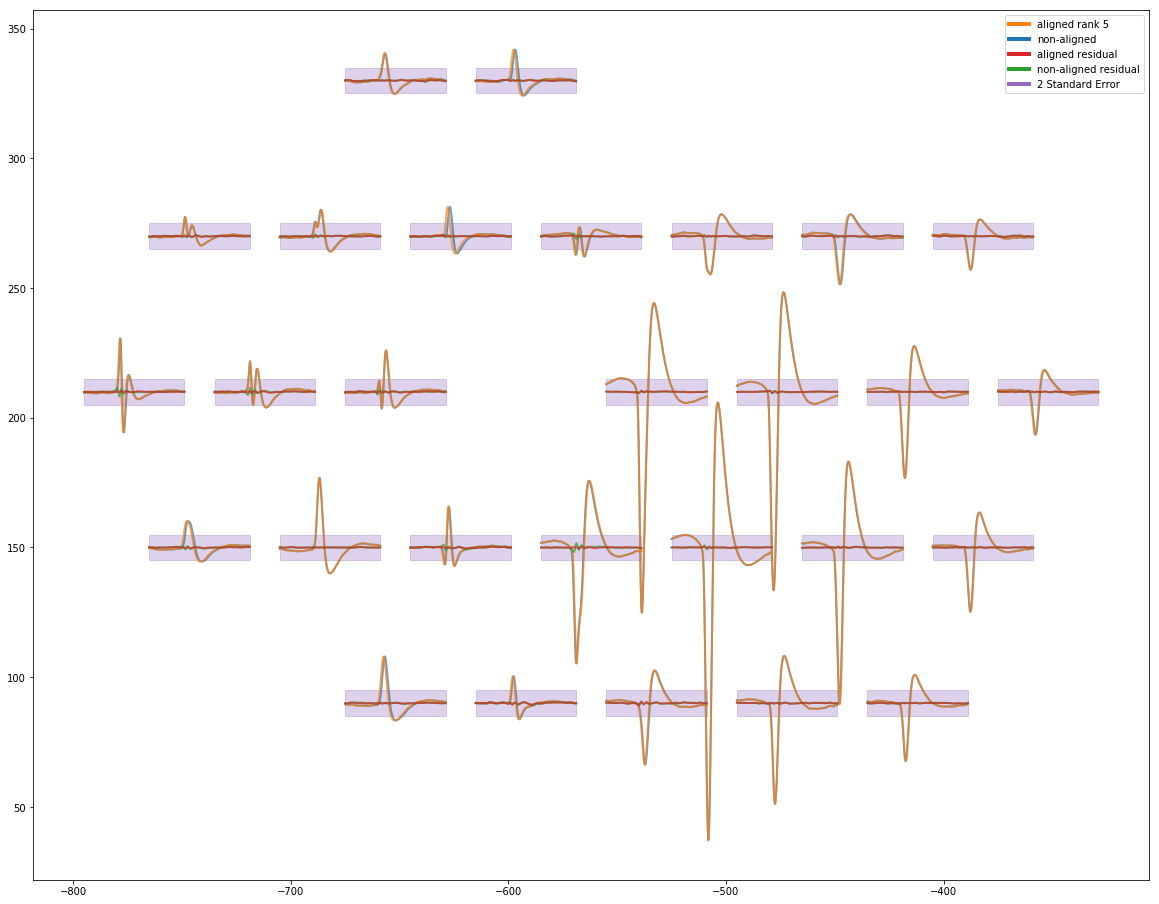

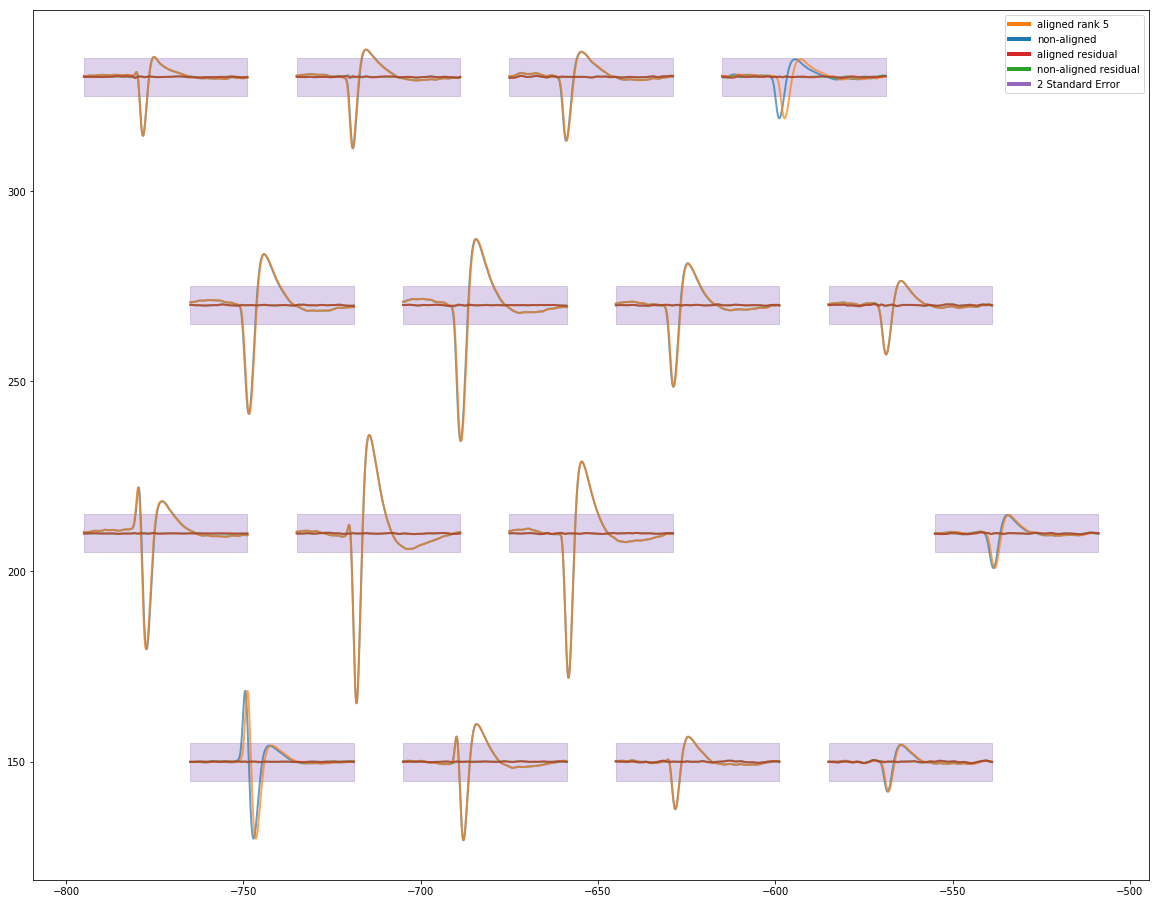

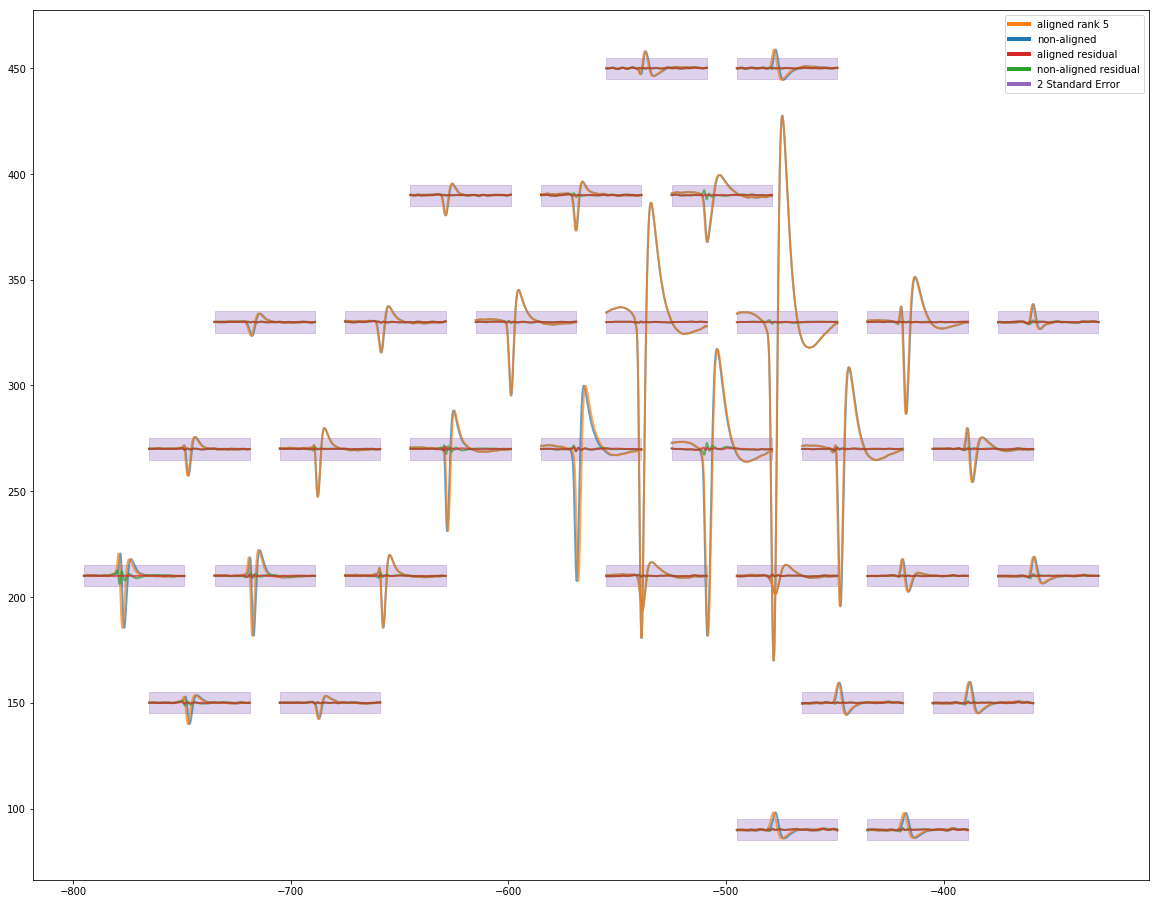

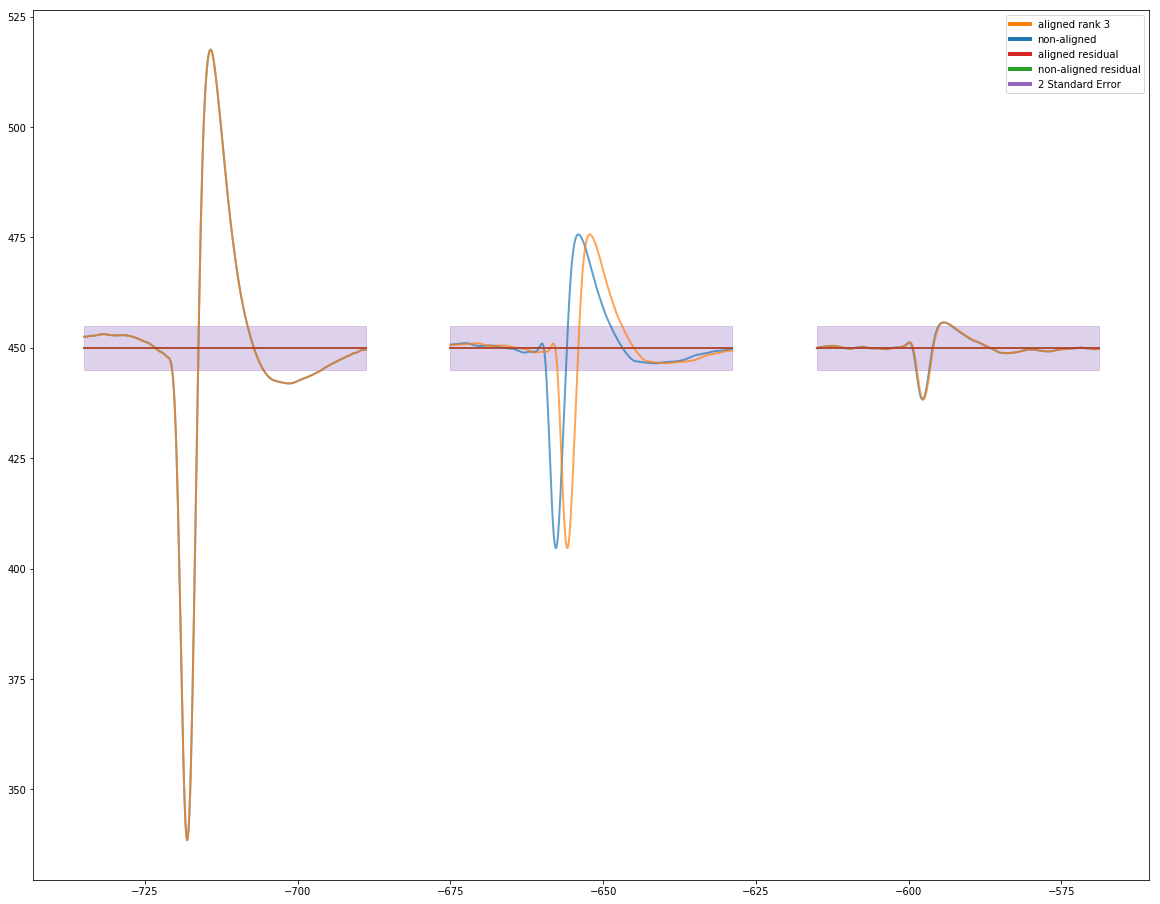

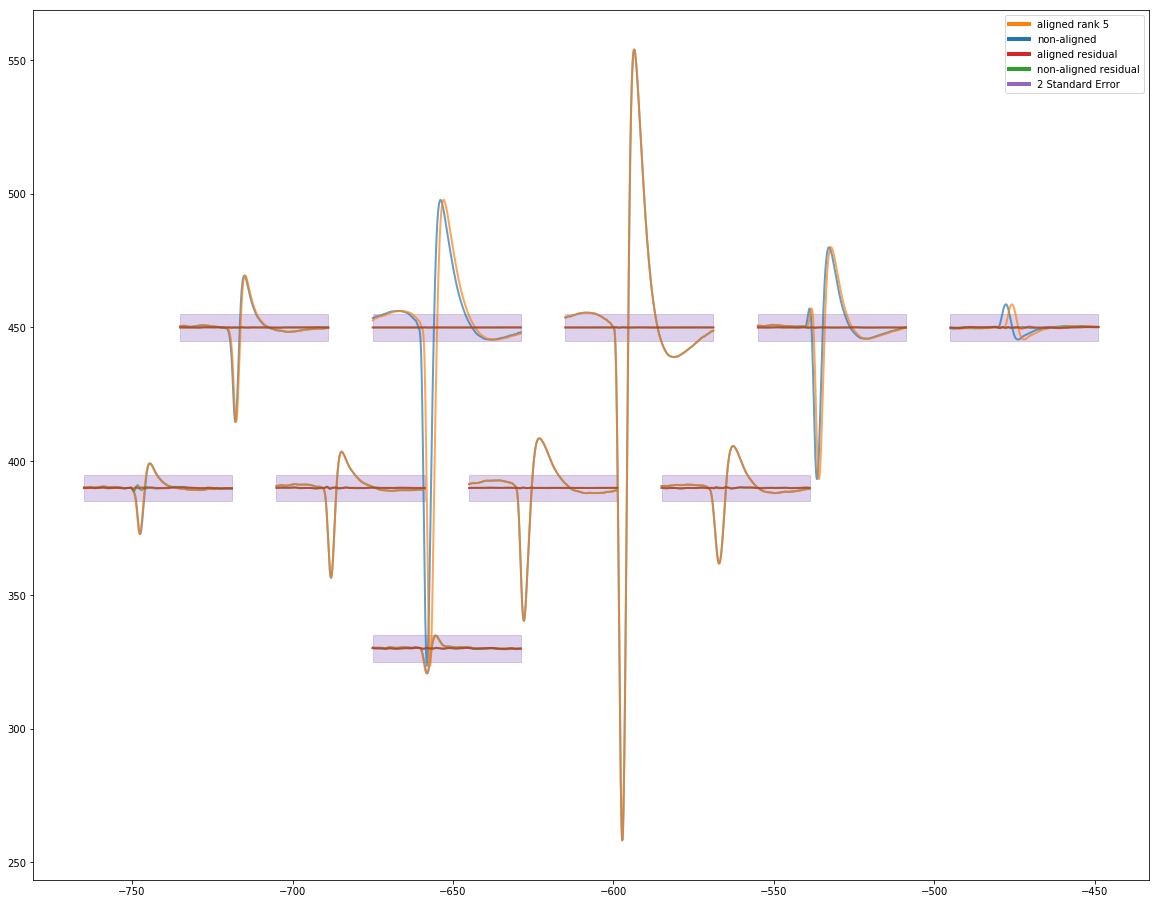

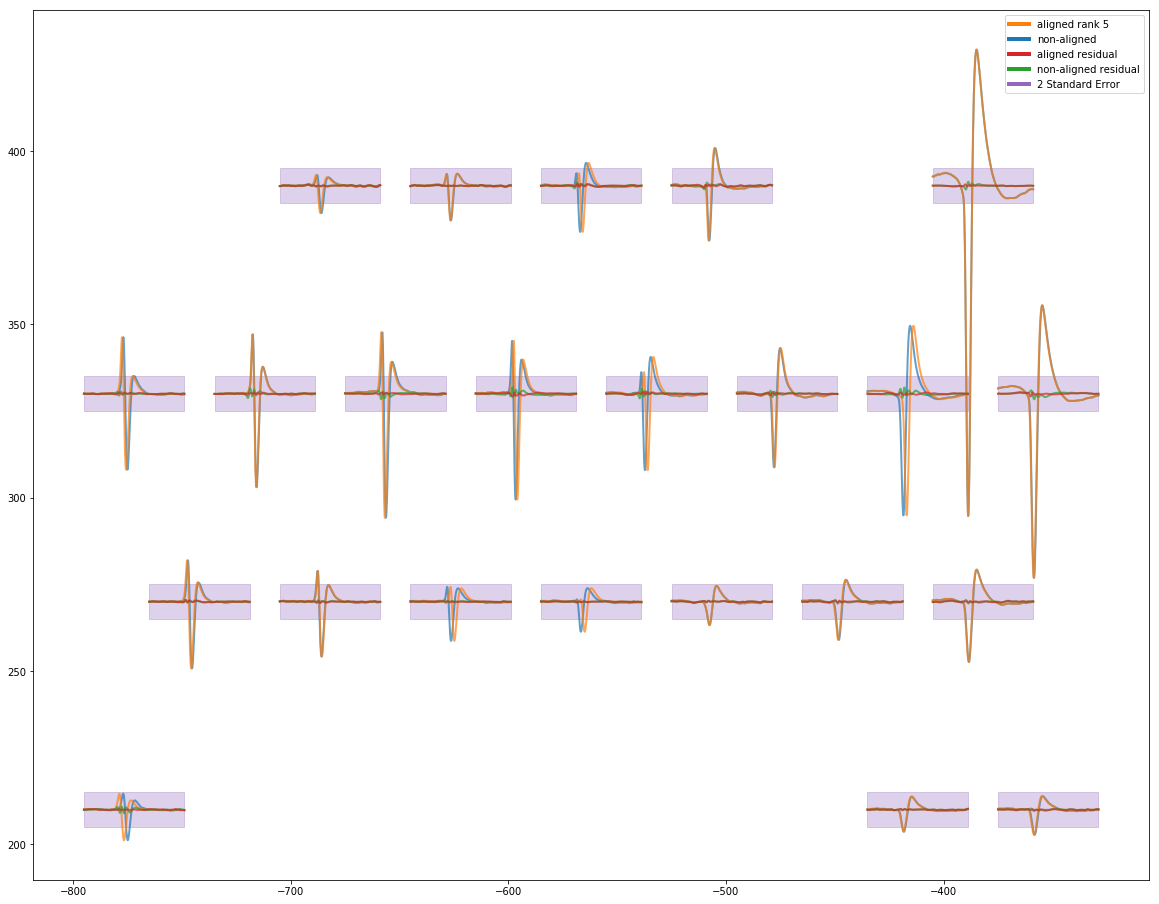

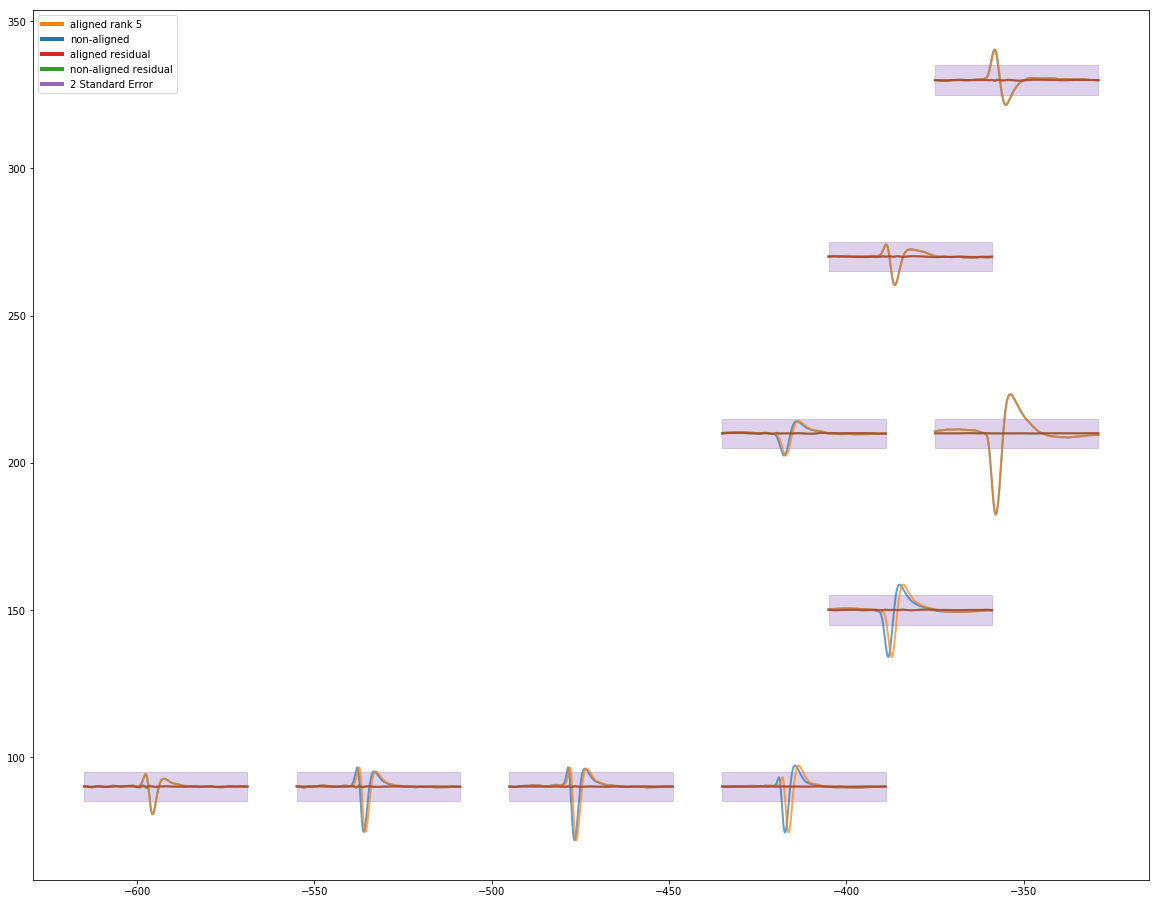

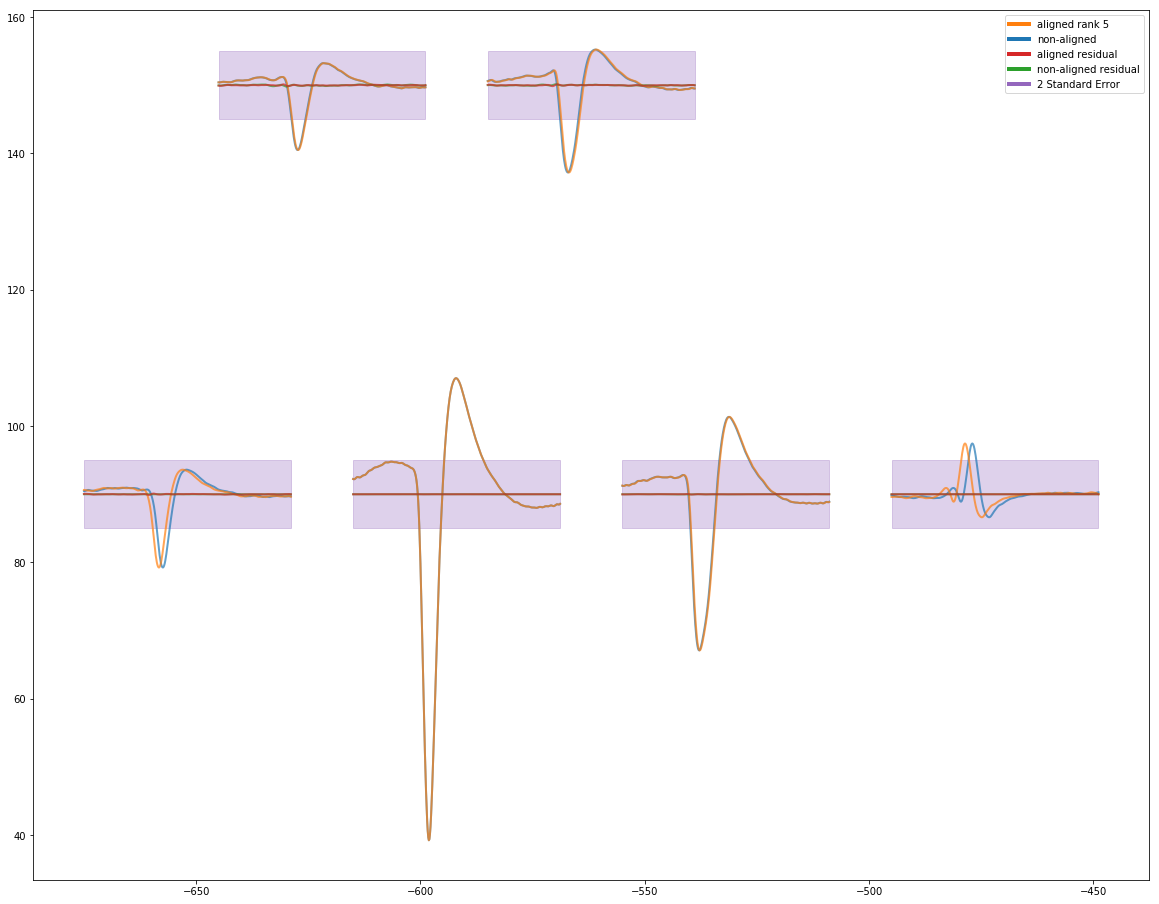

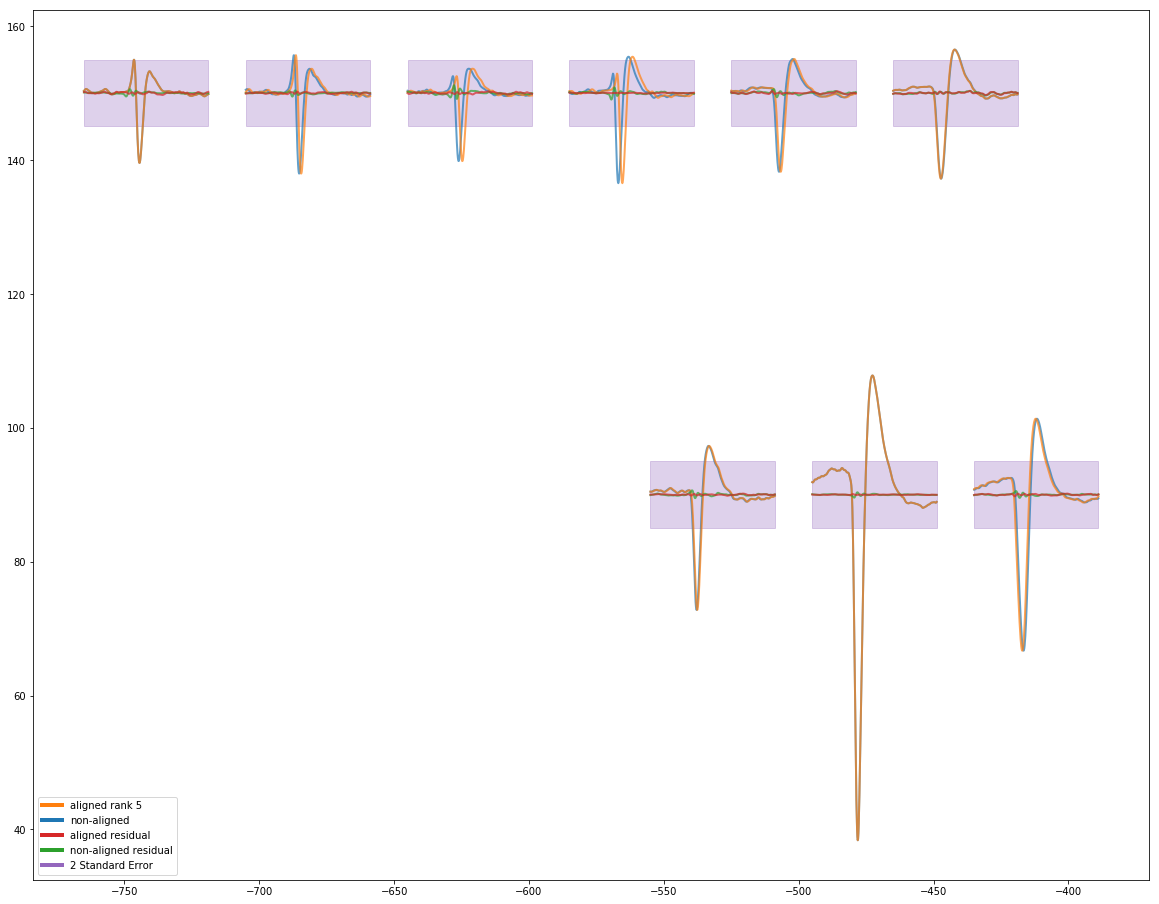

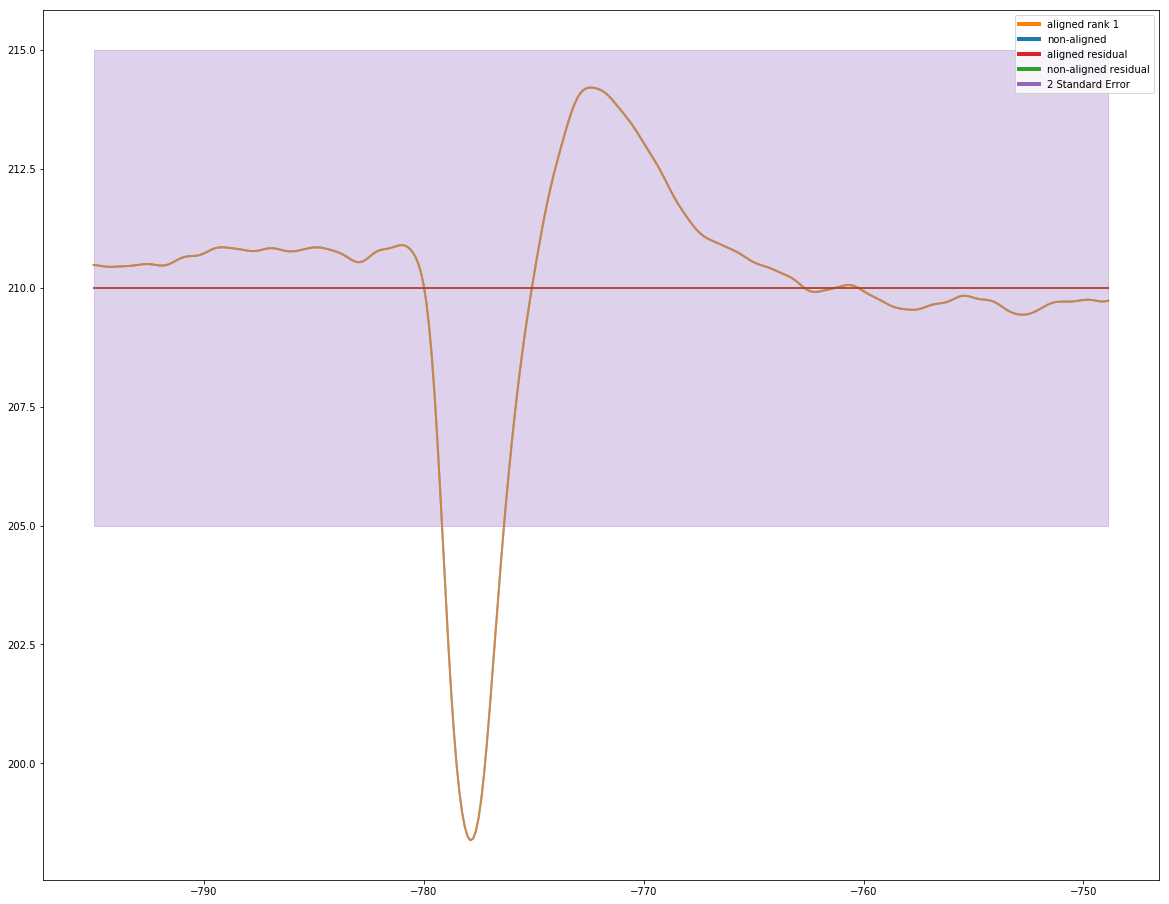

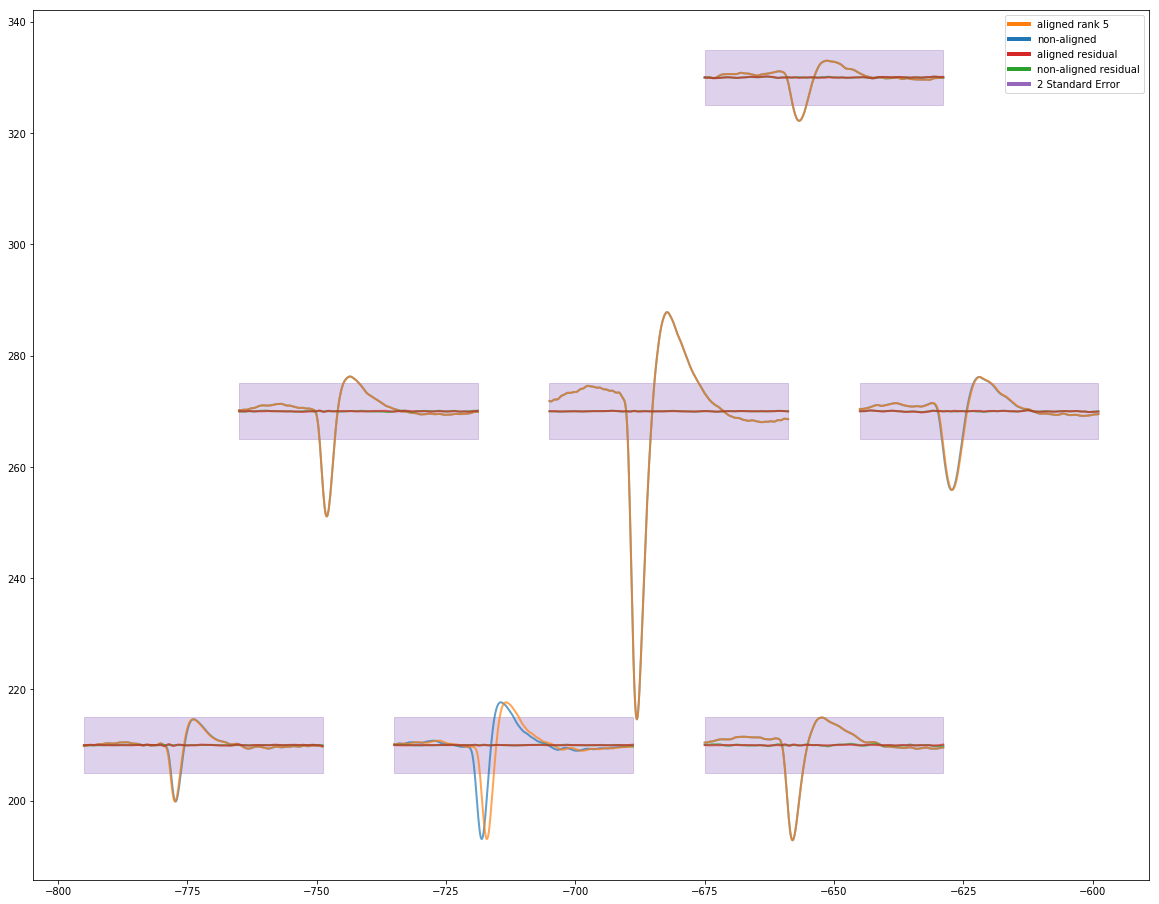

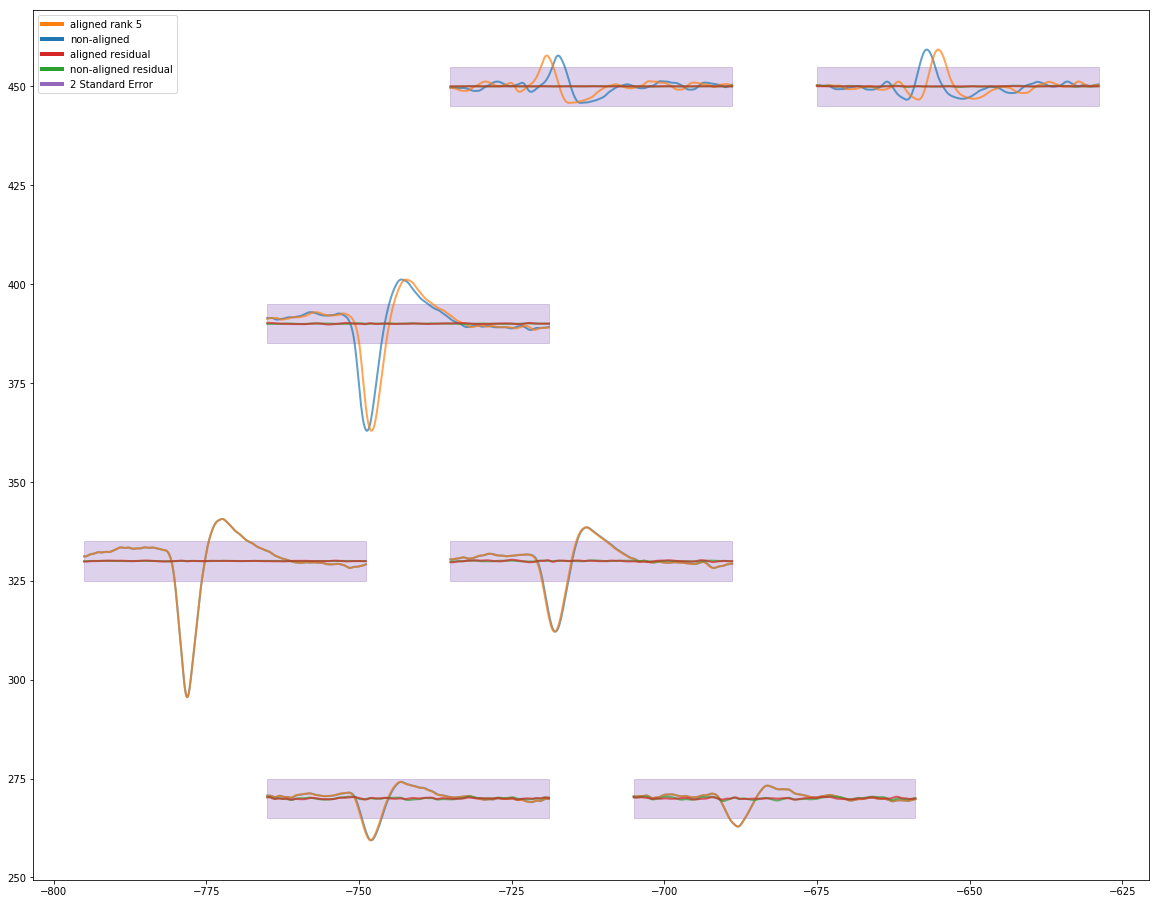

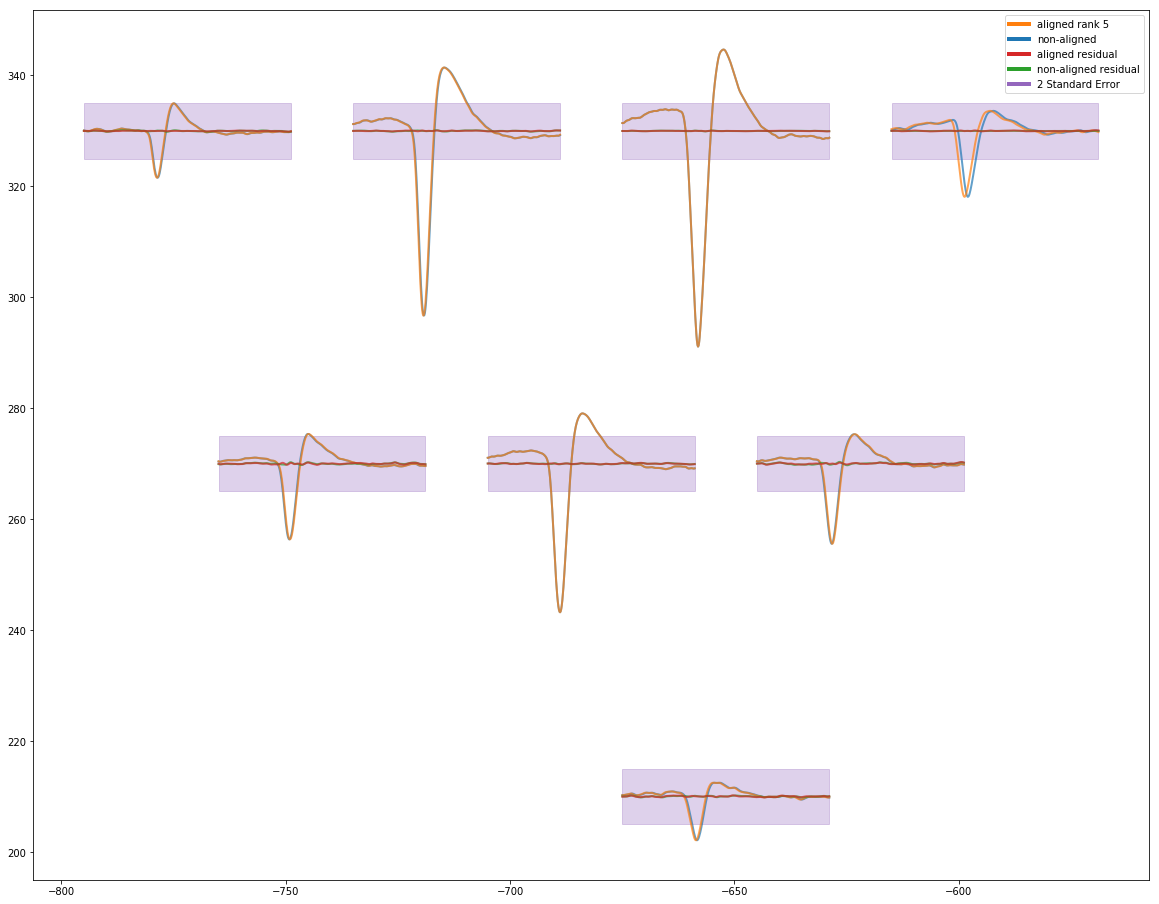

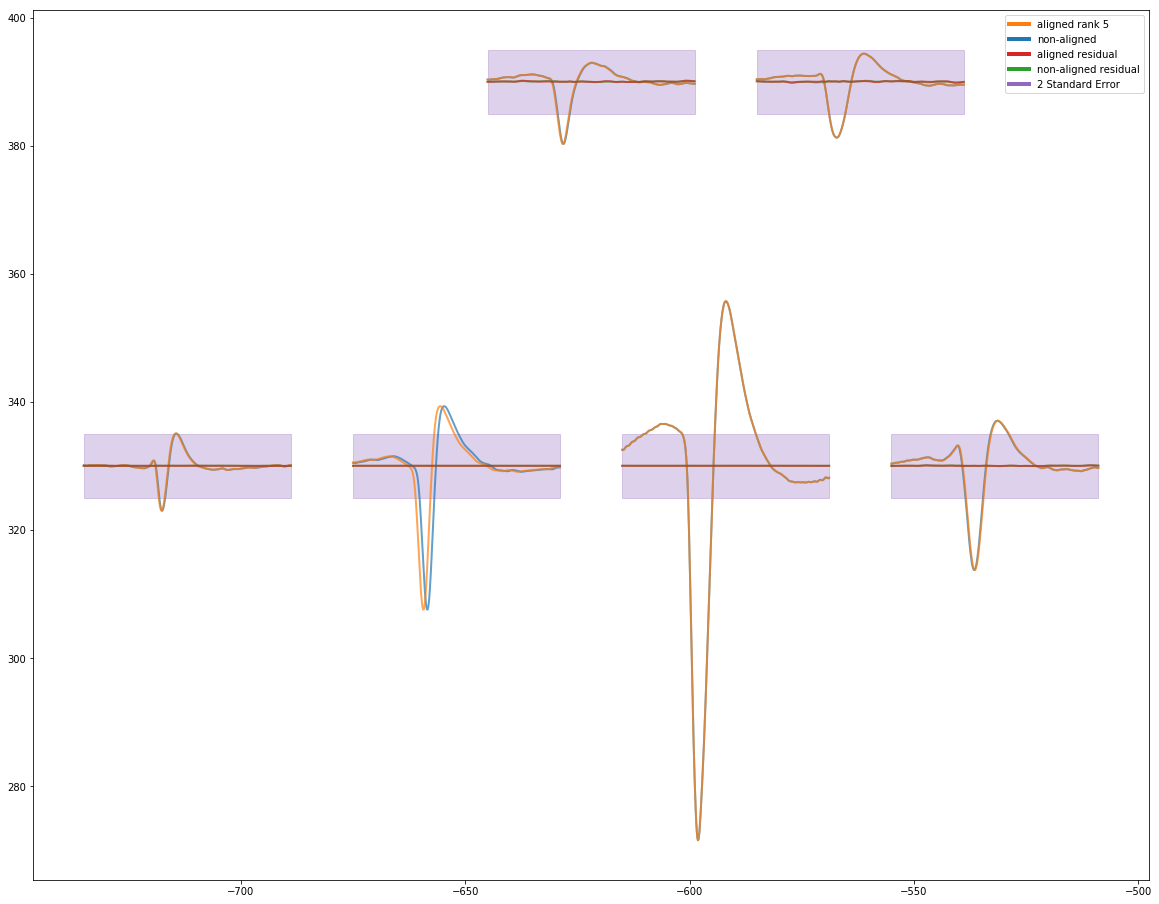

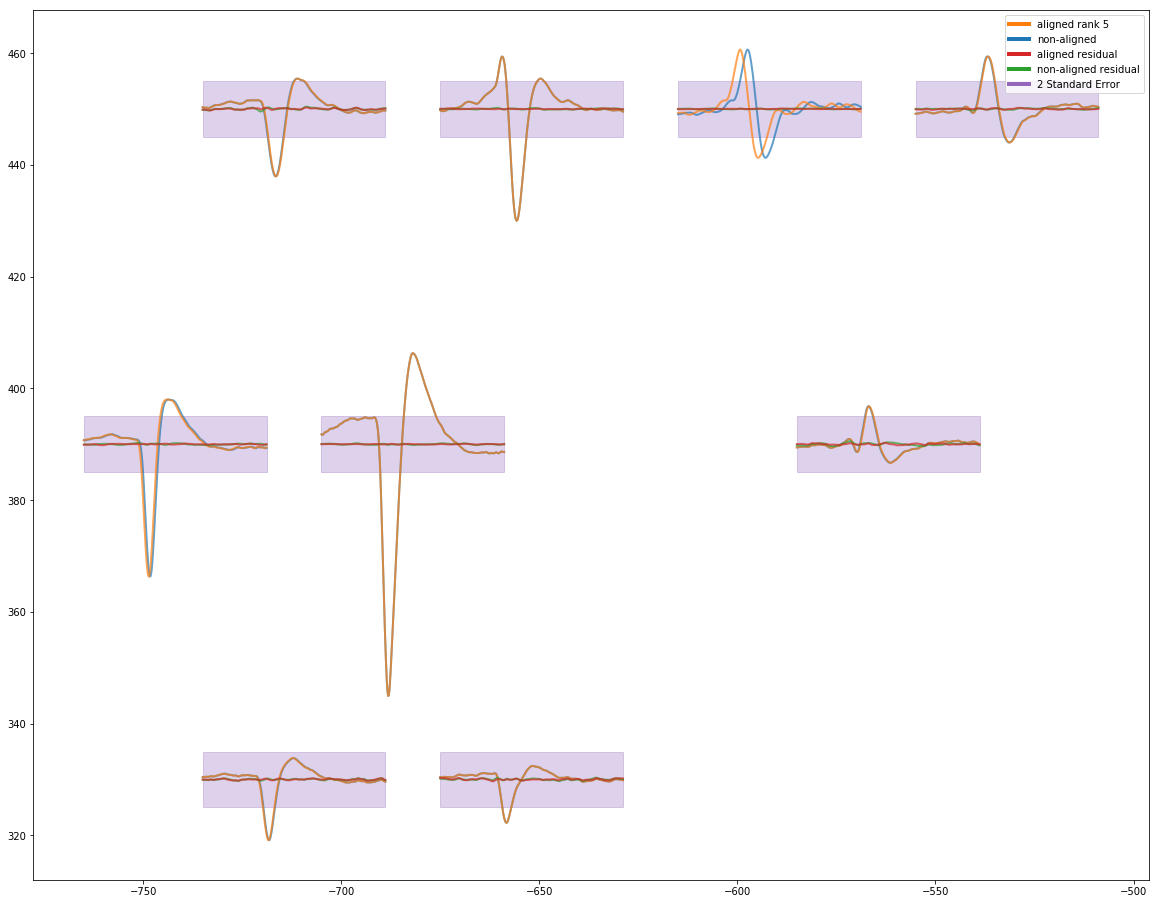

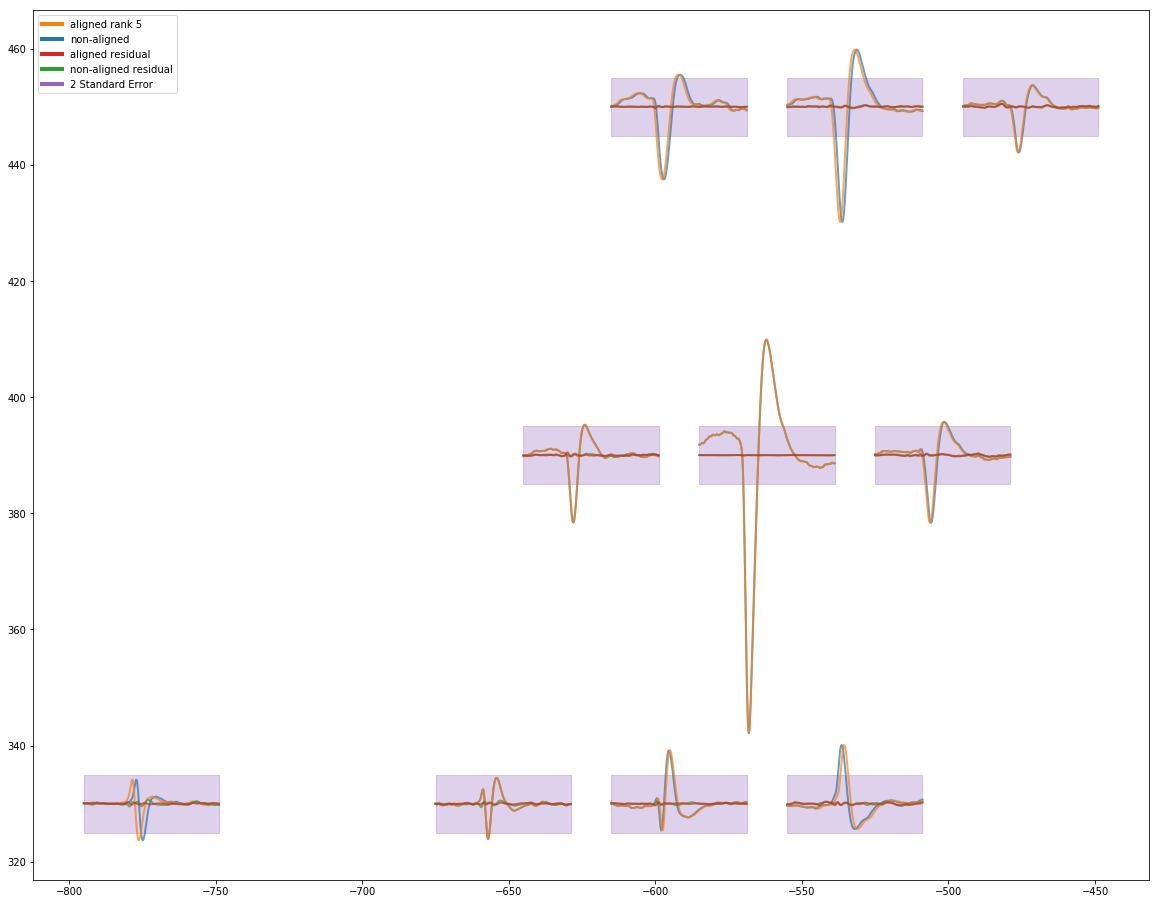

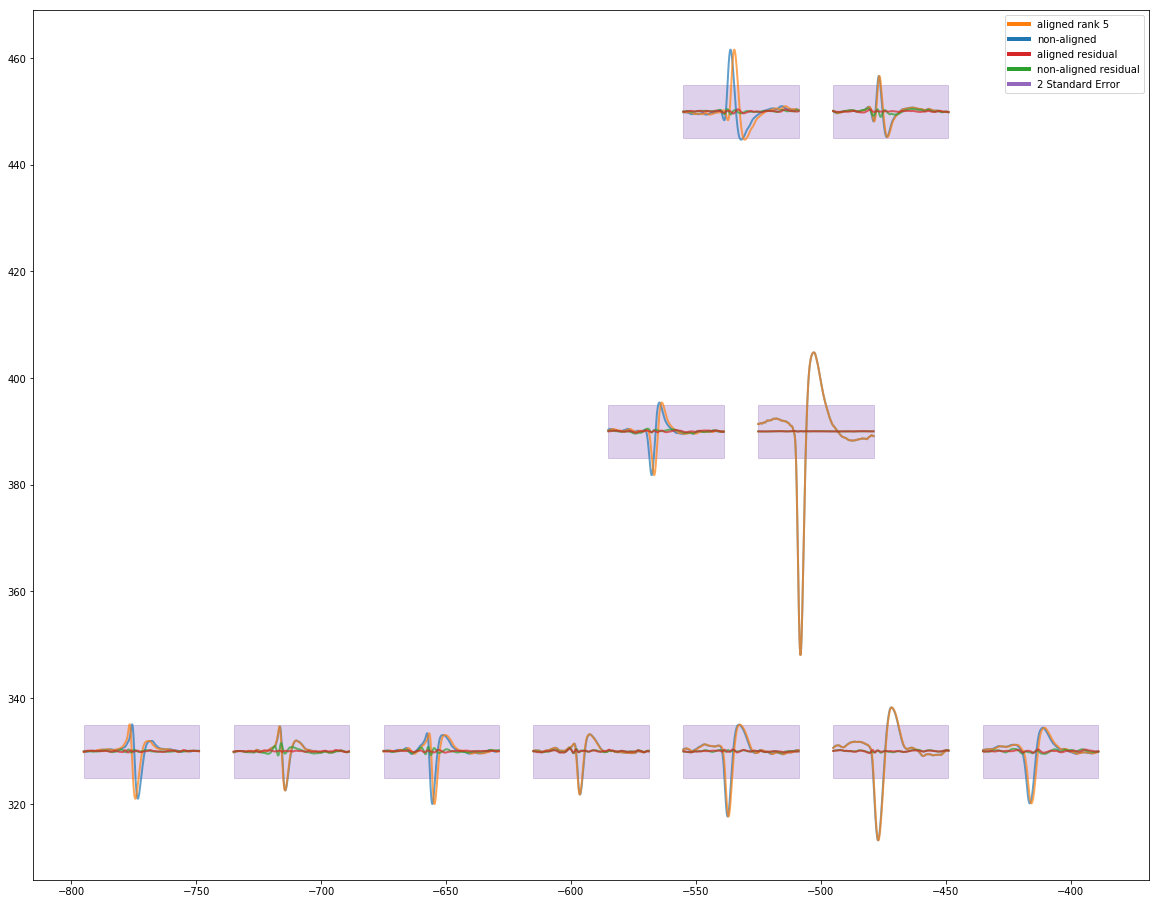

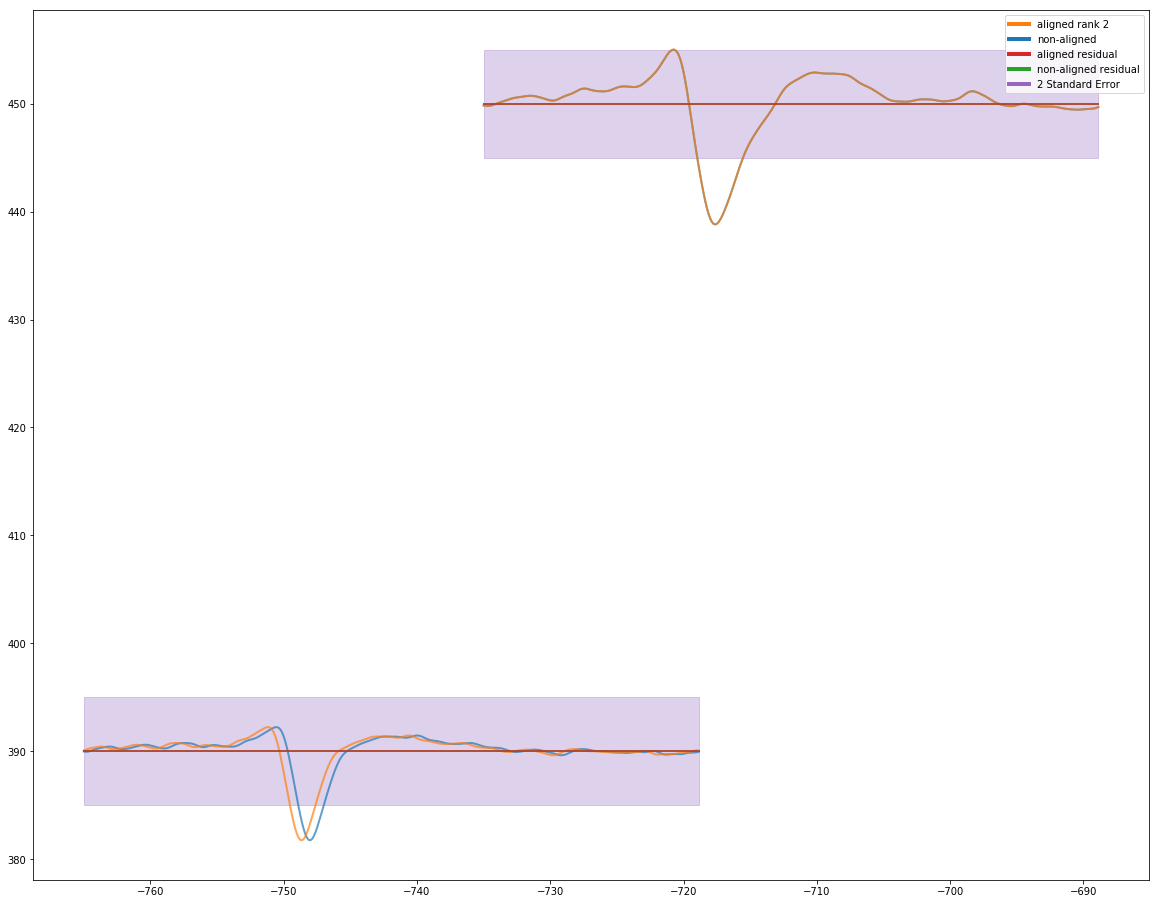

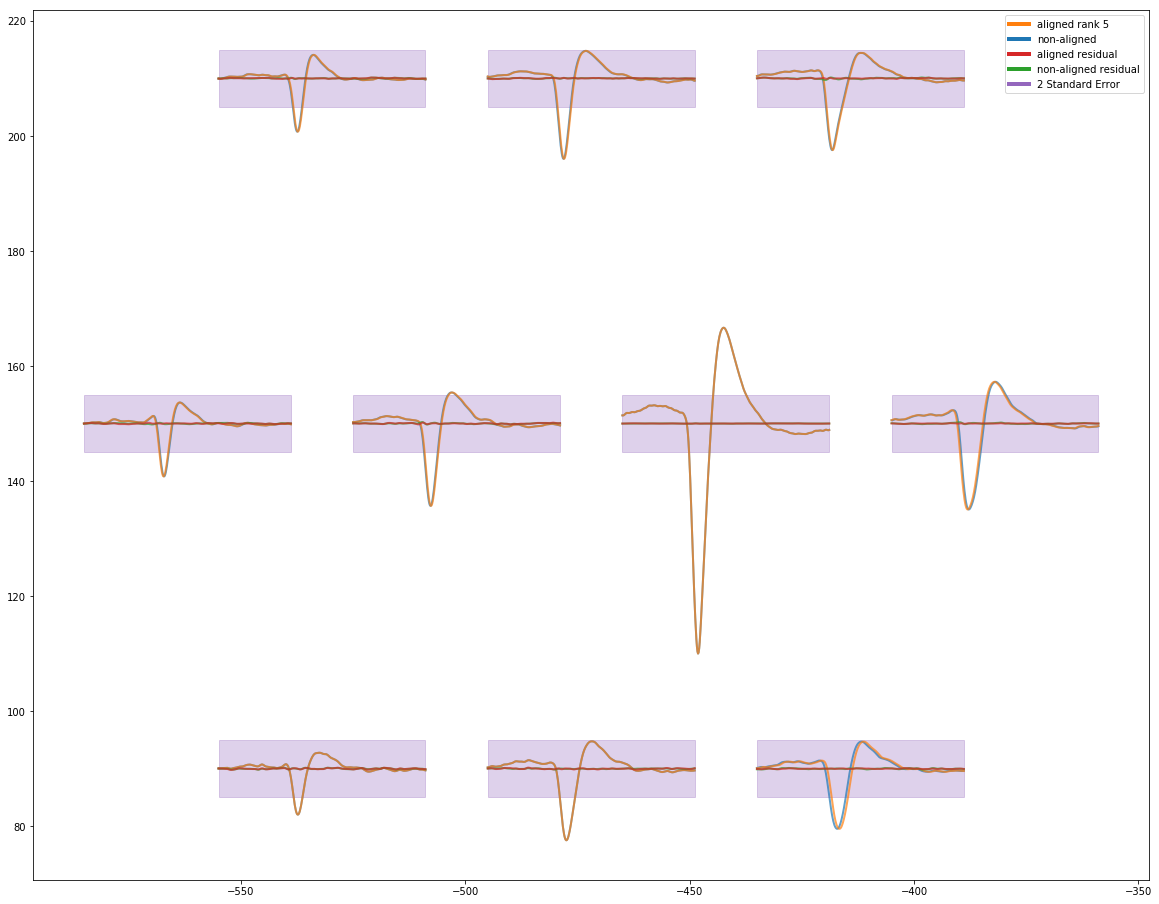

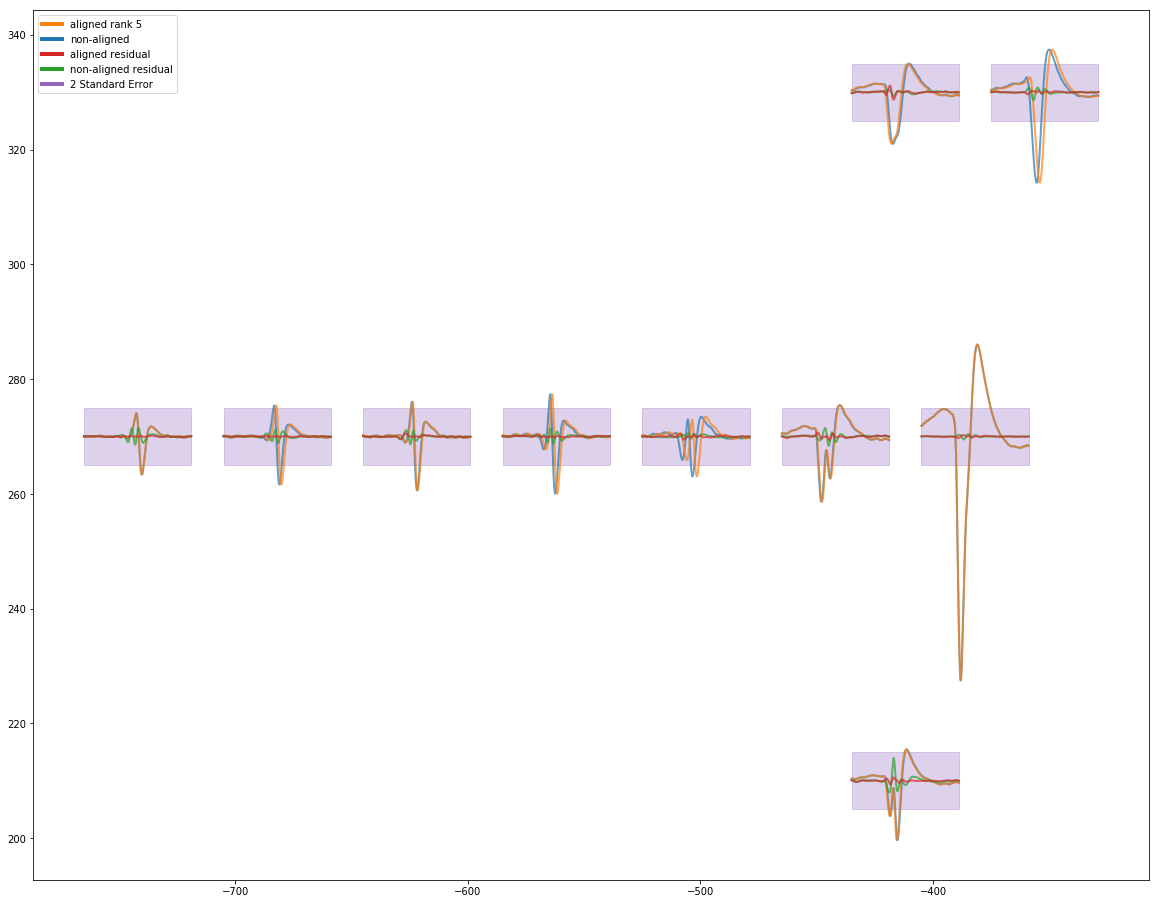

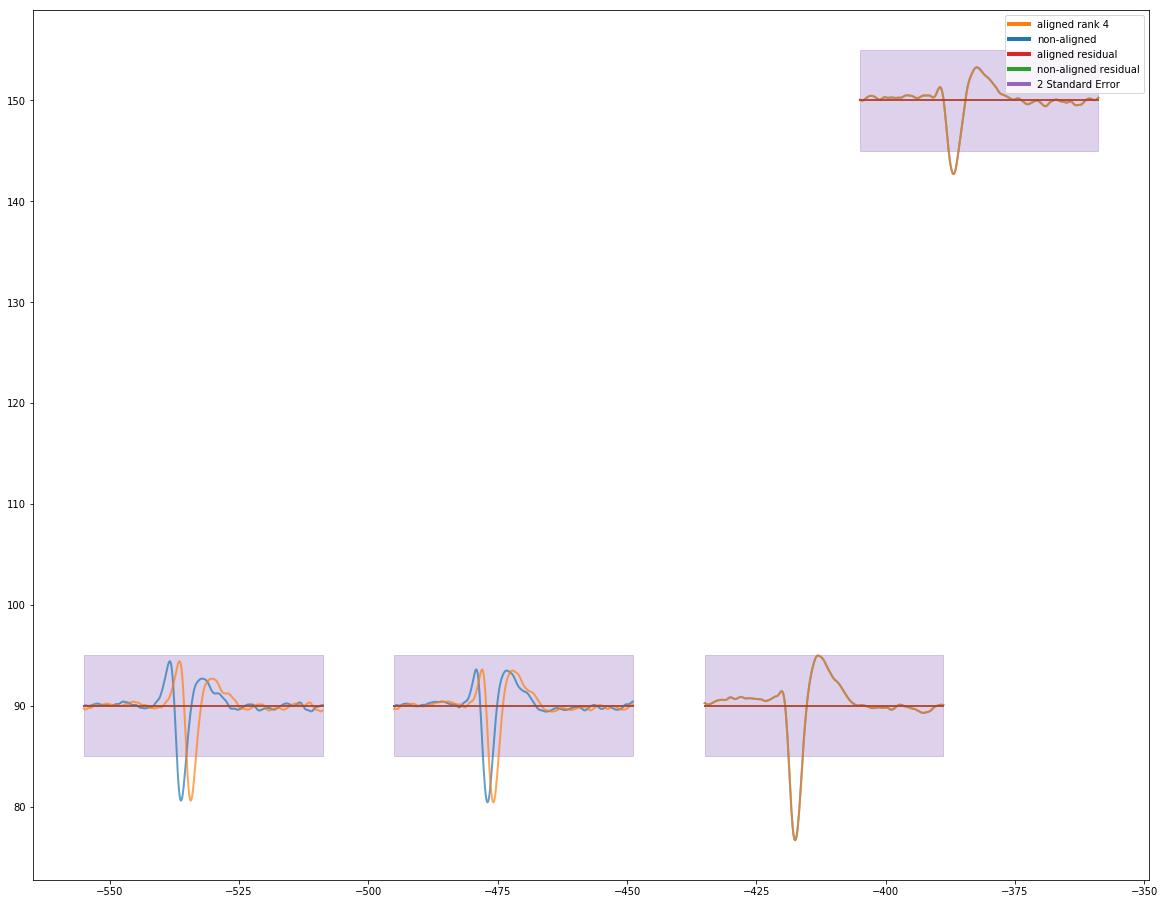

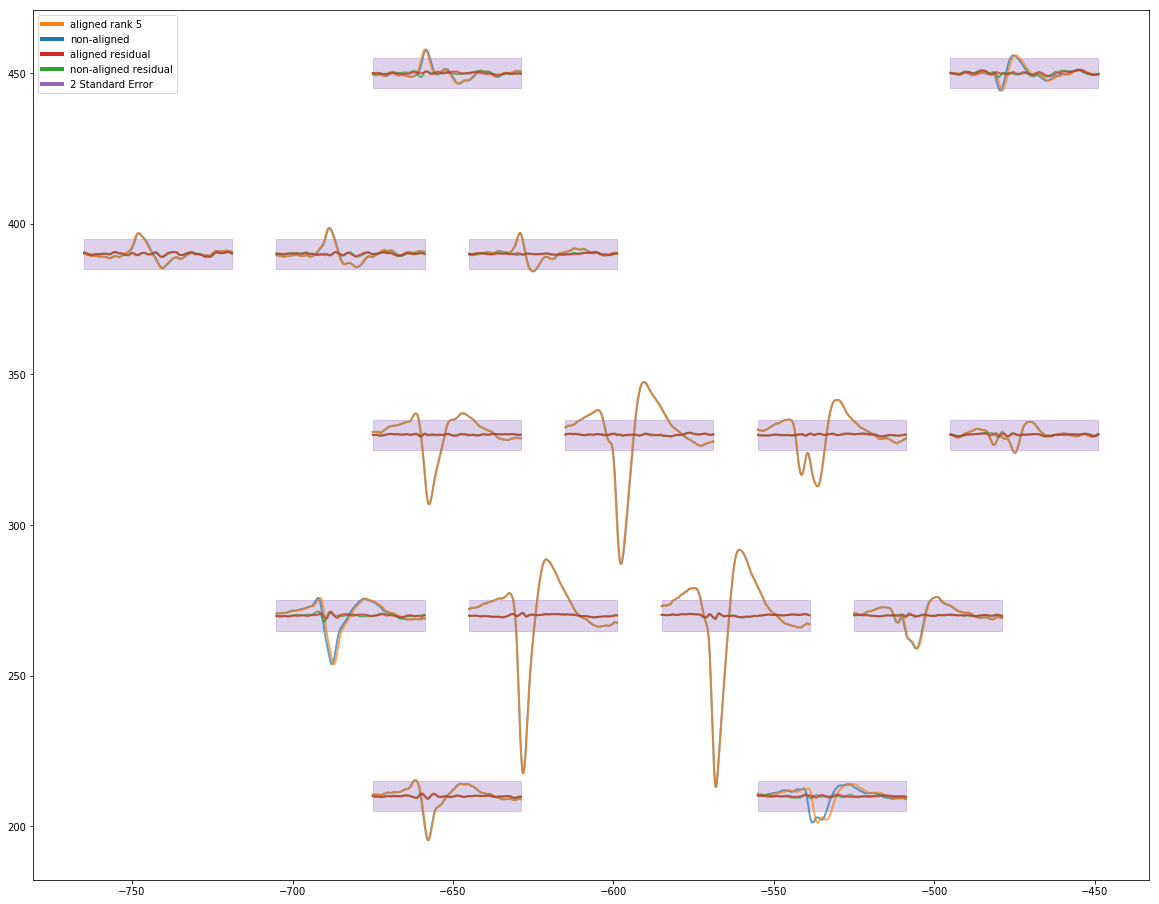

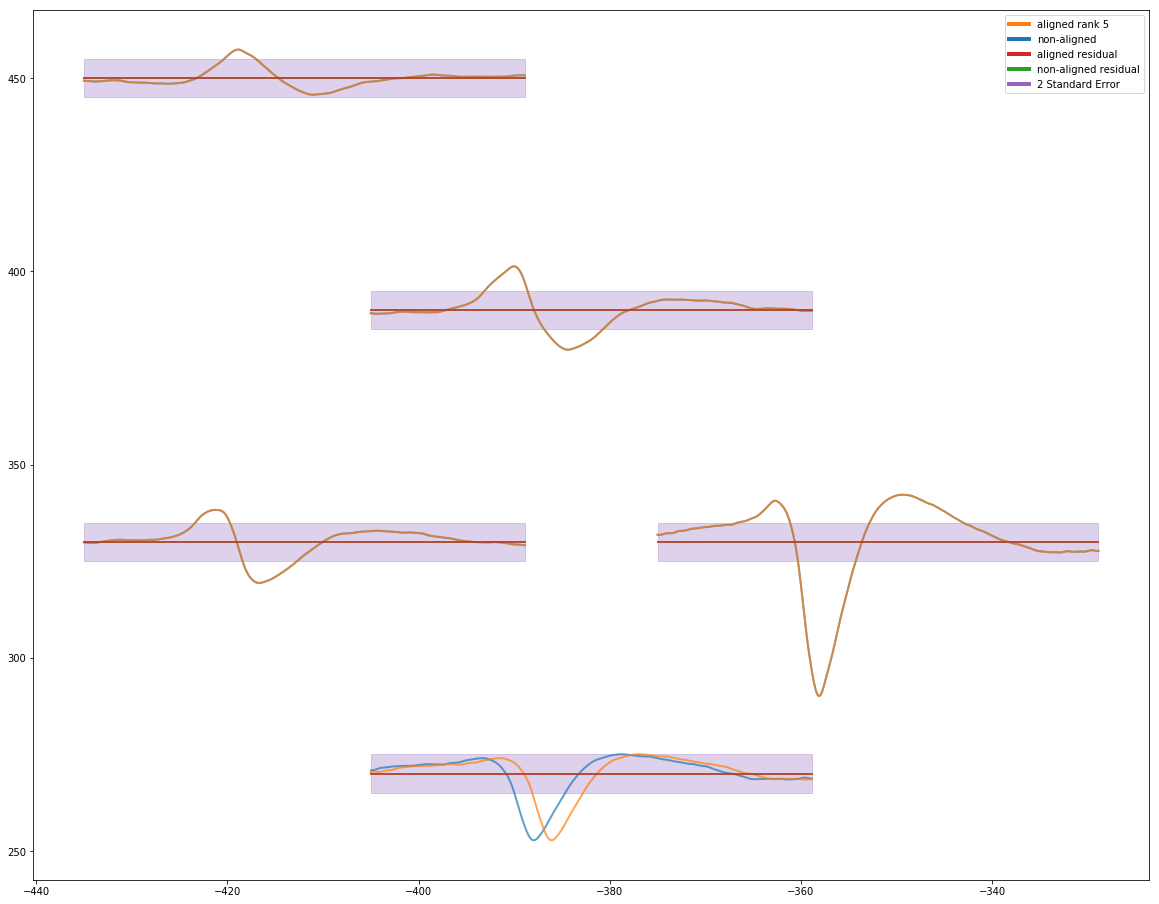

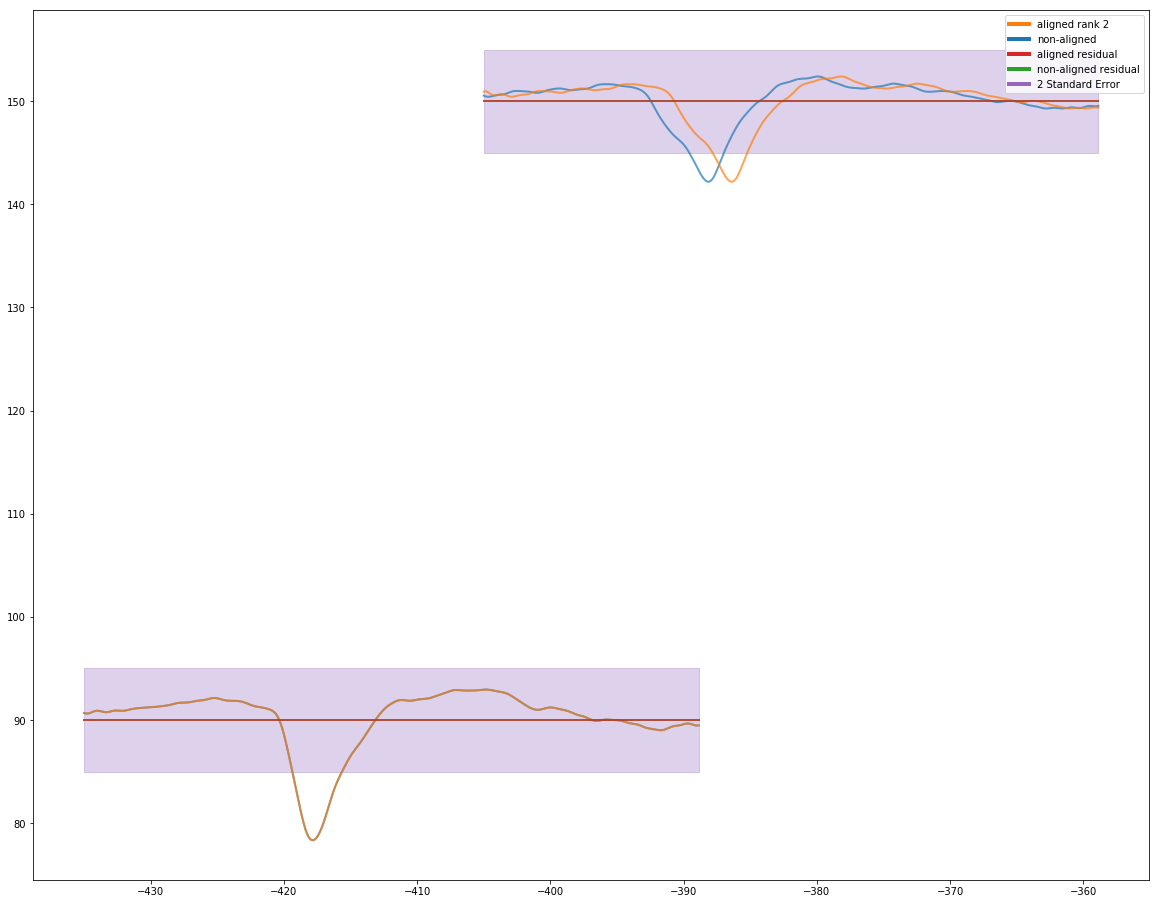

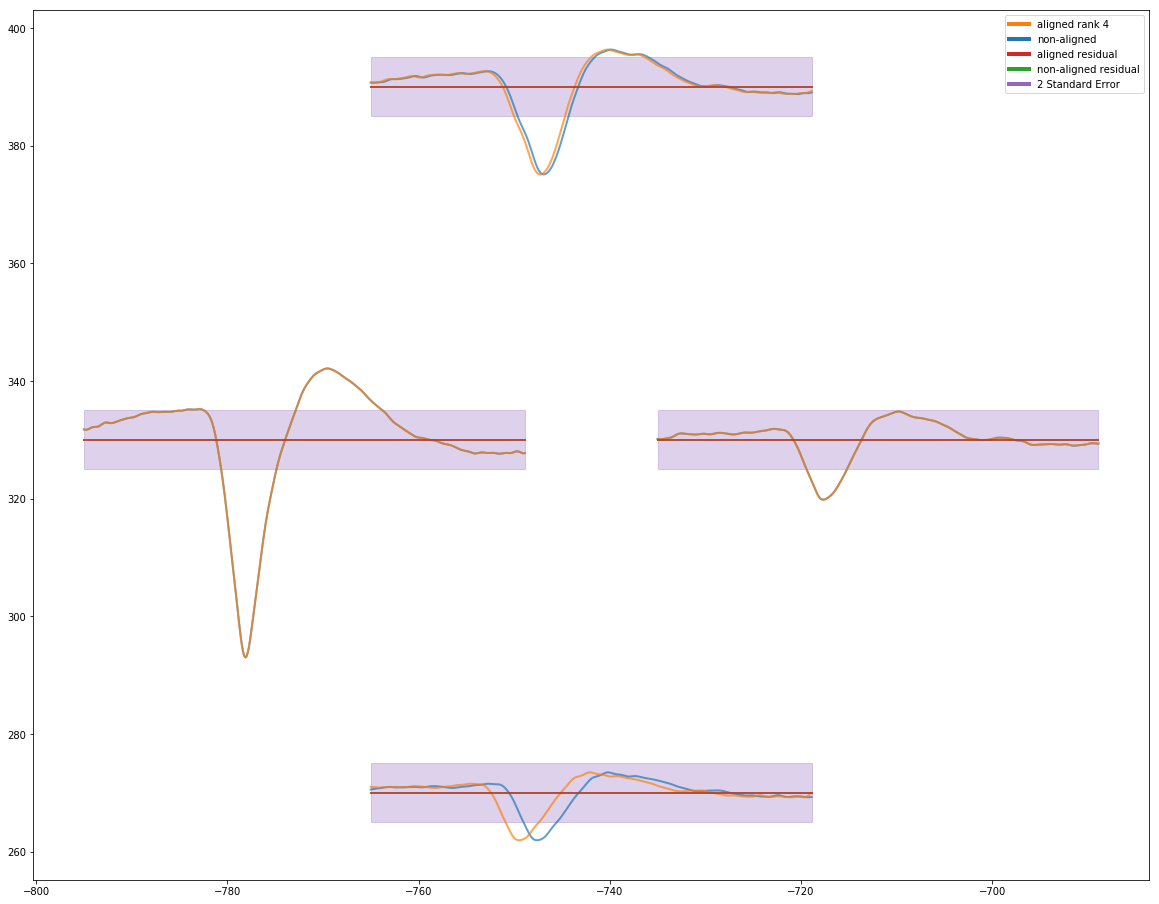

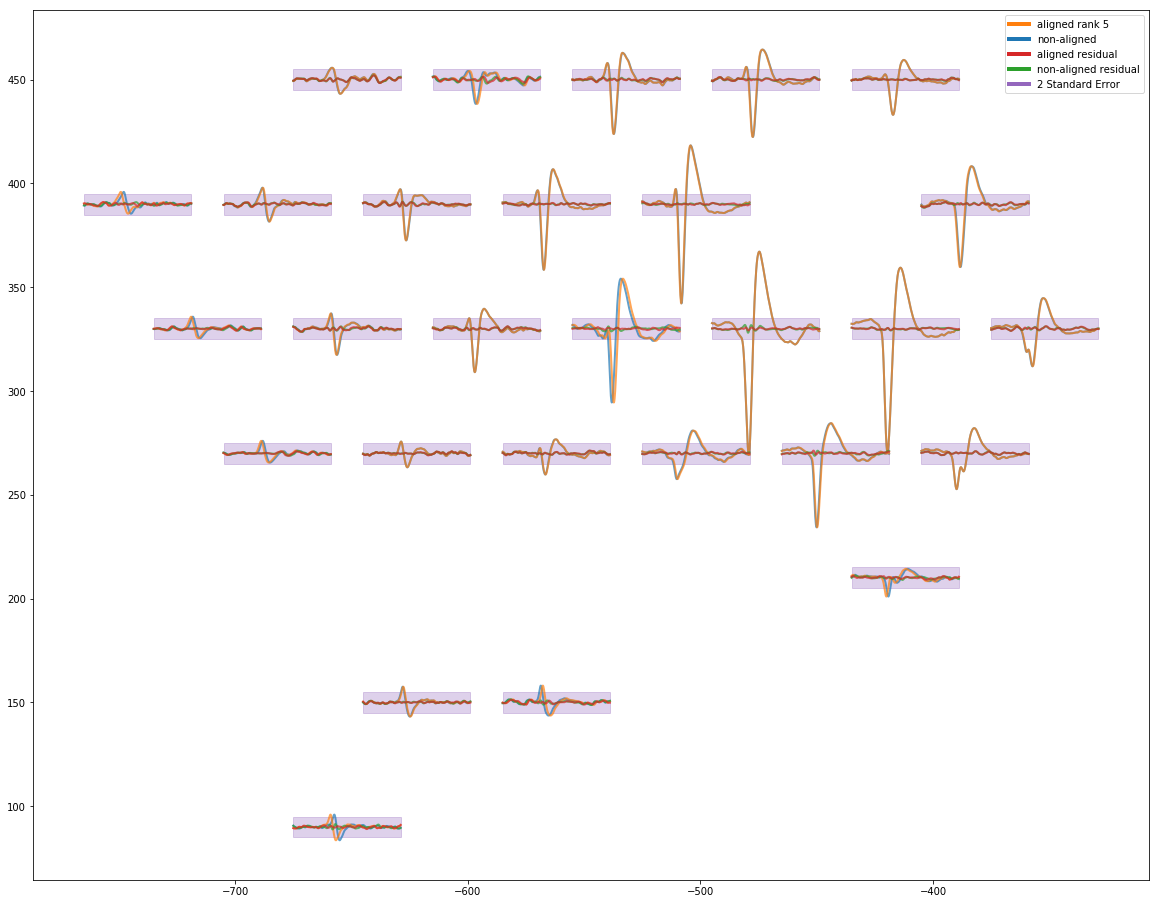

In [102]:
UPSAMPLE = 5
MAX_SHIFT = 6


for u in tqdm(range(mwc.templates.shape[2])):
    fig, ax = plt.subplots()

    RANK = 5 # Param
    temp = mwc.templates[:, :, u]

    g = Geometry(geometry[vis_chan(temp), :])
    vis_geom = geometry[vis_chan(temp), :]
    temp = temp[:, vis_chan(temp)]

    if temp.shape[1] < 1:
        continue
    if temp.shape[1] < RANK:
        RANK = temp.shape[1]

    new_temp, l = optimal_aligned_compress(temp, rank=RANK, upsample=UPSAMPLE, max_shift=MAX_SHIFT)
    #lial_temp = optimal_svd_align(temp, geometry=g, rank=RANK, upsample=UPSAMPLE, max_shift=MAX_SHIFT)

    crop_off = UPSAMPLE * MAX_SHIFT // 2
    temp = sp.signal.resample(temp, temp.shape[0] * UPSAMPLE)[crop_off:-crop_off]

    
    plot_spatial(vis_geom, temp, ax)
    plot_spatial_fill(vis_geom, temp, ax, color='C4')
    plot_spatial(vis_geom, new_temp, ax, color='C1')
    plot_spatial(vis_geom, temp - recon(temp, rank=RANK), ax, color='C2')
    plot_spatial(vis_geom, new_temp - recon(new_temp, rank=RANK), ax, color='C3')
    custom_lines = [Line2D([0], [0], color='C1', lw=4),
                    Line2D([0], [0], color='C0', lw=4),
                    Line2D([0], [0], color='C3', lw=4),
                    Line2D([0], [0], color='C2', lw=4),
                    Line2D([0], [0], color='C4', lw=4)]
    leg_list = ['aligned rank {}'.format(RANK),
                'non-aligned', 'aligned residual', 'non-aligned residual', '2 Standard Error']
    ax.legend(custom_lines, leg_list)

    fig.set_size_inches(20, 16)
    plt.savefig('Unit_{}_rank_{}.pdf'.format(u, RANK))